
# 🎯 Objetivo: Detectar toxicidad con datos aumentados

## 📋 Estrategia:
### - Eliminar columnas desbalanceadas
### - Aplicar Data Augmentation con traducción
### - Preprocesar texto eficientemente
### - Entrenar XGboost

In [17]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Procesamiento de texto
import re
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

try:
    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('wordnet', quiet=True)
except:
    pass

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score 
import xgboost as xgb

# Para augmentación simple
import random
from textblob import TextBlob

# Persistencia
import pickle
from datetime import datetime

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Cargar datos y análisis inicial

In [18]:

df = pd.read_csv('../data/youtoxic_english_1000.csv')
print(f"✅ Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")

# Columnas de toxicidad
columnas_toxicidad = ['IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 
                      'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 
                      'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']



✅ Dataset original: 1000 filas, 15 columnas


# 2. Identificar y eliminar columnas desbalanceadas

In [19]:
print("\n🔍 Analizando balance de columnas...")

# Calcular balance
balance = {}
UMBRAL = 5.0  # 5% mínimo

for col in columnas_toxicidad:
    porcentaje = (df[col].sum() / len(df)) * 100
    balance[col] = porcentaje
    estado = "✅ Mantener" if porcentaje >= UMBRAL else "❌ Eliminar"
    print(f"{col:20} -> {porcentaje:5.1f}% {estado}")

# Seleccionar solo columnas balanceadas
columnas_mantener = [col for col in columnas_toxicidad if balance[col] >= UMBRAL]
columnas_eliminar = [col for col in columnas_toxicidad if balance[col] < UMBRAL]

print(f"\n📊 Resumen:")
print(f"   - Columnas a mantener: {len(columnas_mantener)}")
print(f"   - Columnas a eliminar: {len(columnas_eliminar)}")

# Crear etiqueta binaria solo con columnas balanceadas
df['toxic_binary'] = (df[columnas_mantener].sum(axis=1) > 0).astype(int)

# Eliminar columnas desbalanceadas del dataset
df = df.drop(columns=columnas_eliminar)

print(f"\n✅ Nueva distribución de toxicidad:")
print(df['toxic_binary'].value_counts())
print(f"Porcentaje tóxico: {df['toxic_binary'].mean()*100:.1f}%")


🔍 Analizando balance de columnas...
IsAbusive            ->  35.3% ✅ Mantener
IsThreat             ->   2.1% ❌ Eliminar
IsProvocative        ->  16.1% ✅ Mantener
IsObscene            ->  10.0% ✅ Mantener
IsHatespeech         ->  13.8% ✅ Mantener
IsRacist             ->  12.5% ✅ Mantener
IsNationalist        ->   0.8% ❌ Eliminar
IsSexist             ->   0.1% ❌ Eliminar
IsHomophobic         ->   0.0% ❌ Eliminar
IsReligiousHate      ->   1.2% ❌ Eliminar
IsRadicalism         ->   0.0% ❌ Eliminar

📊 Resumen:
   - Columnas a mantener: 5
   - Columnas a eliminar: 6

✅ Nueva distribución de toxicidad:
toxic_binary
0    538
1    462
Name: count, dtype: int64
Porcentaje tóxico: 46.2%


# 3. Preprocesamiento de texto

In [20]:
print("\n🧹 Preparando funciones de preprocesamiento...")

# Inicializar herramientas
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto(texto):
    """Limpieza rápida y eficiente del texto"""
    if pd.isna(texto):
        return ""
    
    texto = str(texto).lower()
    texto = re.sub(r'@\w+|http\S+|www\S+', '', texto)  # URLs y menciones
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)  # Solo letras
    texto = ' '.join(texto.split())  # Espacios extras
    
    return texto

def procesar_texto(texto):
    """Procesamiento completo con lemmatización"""
    # Tokenizar
    palabras = word_tokenize(texto)
    
    # Filtrar stopwords y palabras cortas
    palabras = [lemmatizer.lemmatize(p) for p in palabras 
                if p not in stop_words and len(p) > 2]
    
    return ' '.join(palabras)


🧹 Preparando funciones de preprocesamiento...


# 4. Data augmentation

In [21]:
print("\n🚀 Iniciando proceso de Data Augmentation...")

# Augmentation con Wordnet (más preciso que sinónimos manuales)
def augmentar_con_wordnet(texto, num_variaciones=2):
    """Usa WordNet para encontrar sinónimos más precisos"""
    variaciones = []
    
    try:
        # Obtener palabras y sus POS tags
        blob = TextBlob(texto)
        palabras_tagged = blob.tags
        
        for _ in range(num_variaciones):
            nuevo_texto = texto
            palabras_cambiadas = 0
            
            for palabra, pos in palabras_tagged:
                if palabras_cambiadas >= 2:  # Cambiar máximo 2 palabras
                    break
                
                # Obtener sinónimos de WordNet
                sinonimos = []
                for syn in wordnet.synsets(palabra):
                    for lemma in syn.lemmas():
                        sinonimo = lemma.name().replace('_', ' ')
                        if sinonimo.lower() != palabra.lower():
                            sinonimos.append(sinonimo)
                
                if sinonimos and random.random() < 0.3:  # 30% probabilidad
                    sinonimo = random.choice(sinonimos[:3])
                    nuevo_texto = nuevo_texto.replace(palabra, sinonimo, 1)
                    palabras_cambiadas += 1
            
            if nuevo_texto != texto:
                variaciones.append(nuevo_texto)
    
    except Exception as e:
        pass
    
    return variaciones

# Back traslation
def back_translation_simple(texto, idiomas=['es', 'fr', 'de']):
    """Traduce a otro idioma y de vuelta al inglés"""
    variaciones = []
    
    for idioma in idiomas:
        try:
            # Traducir al idioma intermedio
            blob_original = TextBlob(texto)
            traducido = blob_original.translate(to=idioma)
            
            # Traducir de vuelta al inglés
            vuelta_ingles = traducido.translate(to='en')
            
            texto_final = str(vuelta_ingles)
            if texto_final != texto and len(texto_final) > 5:
                variaciones.append(texto_final)
        
        except Exception as e:
            continue
    
    return variaciones

# Augmentation contextual avanzado
def augmentar_texto_avanzado_v2(texto):
    """Versión mejorada del augmentation"""
    variaciones = []
    
    # Diccionario de sinónimos más extenso y contextual
    sinonimos_contextuales = {
        'offensive': {
            'hate': ['despise', 'loathe', 'detest', 'abhor'],
            'stupid': ['dumb', 'idiotic', 'foolish', 'moronic', 'brainless'],
            'ugly': ['hideous', 'repulsive', 'disgusting', 'revolting'],
            'kill': ['murder', 'destroy', 'eliminate', 'annihilate'],
            'idiot': ['fool', 'moron', 'imbecile', 'dimwit'],
            'suck': ['terrible', 'awful', 'horrible', 'atrocious'],
            'trash': ['garbage', 'rubbish', 'waste', 'junk']
        },
        'neutral': {
            'good': ['great', 'excellent', 'wonderful', 'amazing'],
            'bad': ['poor', 'subpar', 'inadequate', 'unsatisfactory'],
            'nice': ['pleasant', 'lovely', 'delightful', 'charming'],
            'big': ['large', 'huge', 'enormous', 'massive'],
            'small': ['tiny', 'little', 'miniature', 'compact']
        }
    }
    
    # Técnica 1: Reemplazo contextual
    for categoria, palabras in sinonimos_contextuales.items():
        for palabra, alternativas in palabras.items():
            if palabra in texto.lower():
                for alt in alternativas[:2]:
                    nuevo_texto = texto.lower().replace(palabra, alt)
                    if nuevo_texto != texto.lower():
                        variaciones.append(nuevo_texto)
    
    # Técnica 2: Inserción de intensificadores y modificadores
    intensificadores = ['really', 'very', 'extremely', 'totally', 'completely', 'absolutely', 'quite', 'rather']
    modificadores = ['honestly', 'actually', 'seriously', 'definitely', 'certainly', 'obviously', 'clearly']
    adjetivos = ['stupid', 'dumb', 'ugly', 'bad', 'good', 'nice', 'terrible', 'awful', 'great', 'amazing']
    
    for adj in adjetivos:
        if adj in texto.lower():
            for intensif in intensificadores[:3]:
                nuevo_texto = texto.lower().replace(adj, f"{intensif} {adj}")
                if nuevo_texto != texto.lower():
                    variaciones.append(nuevo_texto)
    
    # Técnica 2.5: Añadir modificadores al inicio
    for mod in modificadores[:3]:
        if len(texto.split()) > 3:  # Solo para textos con más de 3 palabras
            nuevo_texto = f"{mod}, {texto.lower()}"
            if nuevo_texto != texto.lower():
                variaciones.append(nuevo_texto)
    
    # Técnica 3: Cambio de perspectiva
    cambios_perspectiva = [
        ('you are', 'you seem to be'),
        ('you are', 'you appear to be'),
        ('i think', 'in my opinion'),
        ('i believe', 'it seems to me'),
        ('this is', 'this seems to be')
    ]
    
    for original, reemplazo in cambios_perspectiva:
        if original in texto.lower():
            nuevo_texto = texto.lower().replace(original, reemplazo)
            if nuevo_texto != texto.lower():
                variaciones.append(nuevo_texto)
    
    # Técnica 4: Variaciones simples adicionales
    variaciones_simples = [
        f"{texto} really",
        f"{texto} though",
        f"i think {texto}",
        f"honestly {texto}",
        f"{texto} definitely",
        f"actually {texto}",
        f"{texto} for sure"
    ]
    
    for var in variaciones_simples:
        if var.lower() != texto.lower():
            variaciones.append(var.lower())
    
    return list(set(variaciones))[:8]  # Máximo 8 variaciones

# 4. FUNCIÓN PRINCIPAL DE AUGMENTATION
def aumentar_dataset_completo(df_input, columna_texto='Text', columna_label='toxic_binary', 
                             factor_aumento=2.5, usar_back_translation=False):
    """
    Función principal para aumentar el dataset completo
    
    Args:
        df_input: DataFrame original
        columna_texto: Nombre de la columna con texto
        columna_label: Nombre de la columna con labels
        factor_aumento: Factor de aumento (2.5 = 150% más datos)
        usar_back_translation: Si usar back-translation (lento pero efectivo)
    
    Returns:
        DataFrame aumentado
    """
    
    print(f"🔍 Analizando dataset para augmentación...")
    
    # Análisis inicial
    print(f"Dataset original: {len(df_input)} filas")
    distribucion = df_input[columna_label].value_counts()
    print(f"Distribución actual: {dict(distribucion)}")
    
    # Calcular cuántas muestras generar
    total_deseado = int(len(df_input) * factor_aumento)
    muestras_generar = total_deseado - len(df_input)
    
    print(f"Muestras a generar: {muestras_generar}")
    
    # Verificar si hay suficiente desequilibrio para augmentar
    if len(distribucion) < 2:
        print("⚠️ Solo hay una clase en el dataset. No es necesario augmentar.")
        return df_input
    
    # Seleccionar muestras para augmentar (priorizando clase minoritaria)
    clase_minoritaria = distribucion.index[-1]
    df_minoritaria = df_input[df_input[columna_label] == clase_minoritaria]
    df_mayoritaria = df_input[df_input[columna_label] != clase_minoritaria]
    
    print(f"Clase minoritaria ({clase_minoritaria}): {len(df_minoritaria)} muestras")
    print(f"Clase mayoritaria: {len(df_mayoritaria)} muestras")
    
    # ESTRATEGIA DE BALANCEO PERFECTO (50-50)
    print("⚖️ Aplicando estrategia de balanceo perfecto...")
    
    # Determinar el número objetivo para cada clase (50-50)
    total_objetivo_por_clase = total_deseado // 2
    
    # Calcular cuántas muestras generar para cada clase
    muestras_gen_minoritaria = total_objetivo_por_clase - len(df_minoritaria)
    muestras_gen_mayoritaria = total_objetivo_por_clase - len(df_mayoritaria)
    
    print(f"Objetivo por clase: {total_objetivo_por_clase} muestras")
    print(f"Clase minoritaria ({clase_minoritaria}): {len(df_minoritaria)} → {total_objetivo_por_clase} (generar {muestras_gen_minoritaria})")
    print(f"Clase mayoritaria: {len(df_mayoritaria)} → {total_objetivo_por_clase} (generar {muestras_gen_mayoritaria})")
    
    # Ajustar números si son negativos
    muestras_gen_minoritaria = max(0, muestras_gen_minoritaria)
    muestras_gen_mayoritaria = max(0, muestras_gen_mayoritaria)
    
    # Generar muestras
    datos_nuevos = []
    
    # Augmentar clase minoritaria (BALANCEO)
    print("📈 Augmentando clase minoritaria (balanceo perfecto)...")
    if len(df_minoritaria) > 0 and muestras_gen_minoritaria > 0:
        contador_minoritaria = 0
        intentos = 0
        max_intentos = 8  # Más intentos
        
        while contador_minoritaria < muestras_gen_minoritaria and intentos < max_intentos:
            print(f"   - Ciclo {intentos + 1}: Generadas {contador_minoritaria}/{muestras_gen_minoritaria} muestras")
            
            for _, row in df_minoritaria.iterrows():
                if contador_minoritaria >= muestras_gen_minoritaria:
                    break
                    
                texto_original = row[columna_texto]
                
                # Generar múltiples variaciones usando TODAS las técnicas
                variaciones = []
                variaciones.extend(augmentar_texto_avanzado_v2(texto_original))
                variaciones.extend(augmentar_con_wordnet(texto_original, num_variaciones=4))
                
                if usar_back_translation:
                    variaciones.extend(back_translation_simple(texto_original))
                
                # Si no hay suficientes variaciones, crear variaciones simples
                if len(variaciones) < 5:
                    # Añadir variaciones simples con modificaciones menores
                    variaciones.append(texto_original + " really")
                    variaciones.append("honestly " + texto_original)
                    variaciones.append(texto_original.replace(".", " definitely.") if "." in texto_original else texto_original + " definitely")
                    variaciones.append("actually " + texto_original)
                    variaciones.append(texto_original + " for sure")
                
                # Usar todas las variaciones disponibles
                for variacion in variaciones:
                    if contador_minoritaria >= muestras_gen_minoritaria:
                        break
                    if variacion and len(variacion.strip()) > 5:  # Verificar que sea válida
                        nueva_fila = row.copy()
                        nueva_fila[columna_texto] = variacion
                        datos_nuevos.append(nueva_fila)
                        contador_minoritaria += 1
            
            intentos += 1
        
        print(f"   - Clase minoritaria: {contador_minoritaria} muestras generadas")
    
    # Augmentar clase mayoritaria (BALANCEO)
    print("📊 Augmentando clase mayoritaria (balanceo perfecto)...")
    if muestras_gen_mayoritaria > 0 and len(df_mayoritaria) > 0:
        contador_mayoritaria = 0
        intentos = 0
        max_intentos = 6  # Suficientes intentos para balanceo
        
        while contador_mayoritaria < muestras_gen_mayoritaria and intentos < max_intentos:
            print(f"   - Ciclo {intentos + 1}: Generadas {contador_mayoritaria}/{muestras_gen_mayoritaria} muestras")
            
            for _, row in df_mayoritaria.iterrows():
                if contador_mayoritaria >= muestras_gen_mayoritaria:
                    break
                    
                texto_original = row[columna_texto]
                
                # Generar múltiples variaciones
                variaciones = []
                variaciones.extend(augmentar_texto_avanzado_v2(texto_original))
                variaciones.extend(augmentar_con_wordnet(texto_original, num_variaciones=3))
                
                # Si no hay suficientes variaciones, crear variaciones simples
                if len(variaciones) < 4:
                    variaciones.append(texto_original + " though")
                    variaciones.append("i think " + texto_original)
                    variaciones.append(texto_original + " probably")
                    variaciones.append("maybe " + texto_original)
                
                # Usar múltiples variaciones por texto
                for variacion in variaciones:
                    if contador_mayoritaria >= muestras_gen_mayoritaria:
                        break
                    if variacion and len(variacion.strip()) > 5:  # Verificar que sea válida
                        nueva_fila = row.copy()
                        nueva_fila[columna_texto] = variacion
                        datos_nuevos.append(nueva_fila)
                        contador_mayoritaria += 1
            
            intentos += 1
        
        print(f"   - Clase mayoritaria: {contador_mayoritaria} muestras generadas")
    
    # Combinar datasets
    if datos_nuevos:
        df_nuevos = pd.DataFrame(datos_nuevos)
        df_final = pd.concat([df_input, df_nuevos], ignore_index=True)
        print(f"✅ Se generaron {len(datos_nuevos)} nuevas muestras")
    else:
        df_final = df_input.copy()
        print("⚠️ No se generaron datos nuevos.")
    
    # Resultados
    print(f"\n📊 Resultados del augmentation:")
    print(f"Dataset original: {len(df_input)} filas")
    print(f"Dataset aumentado: {len(df_final)} filas")
    if len(df_final) > len(df_input):
        incremento = ((len(df_final) - len(df_input)) / len(df_input) * 100)
        print(f"Incremento: {len(df_final) - len(df_input)} filas ({incremento:.1f}%)")
    
    # Nueva distribución
    nueva_distribucion = df_final[columna_label].value_counts()
    print(f"Nueva distribución: {dict(nueva_distribucion)}")
    
    return df_final

# 🚀 EJECUTAR AUGMENTATION EN TU DATASET
print(f"\n📋 Dataset actual antes del augmentation:")
print(f"   - Filas: {len(df)}")
print(f"   - Columnas: {list(df.columns)}")
print(f"   - Distribución toxic_binary: {dict(df['toxic_binary'].value_counts())}")

# Ejecutar augmentación en tu dataset existente
df_aumentado = aumentar_dataset_completo(
    df_input=df,  # Tu dataset ya procesado
    columna_texto='Text',  # Columna de texto en tu dataset
    columna_label='toxic_binary',  # Tu columna de etiquetas binarias
    factor_aumento=2.5,  # 150% más datos para llegar a ~2500
    usar_back_translation=False  # Cambiar a True si quieres aún más variedad (más lento)
)

# CREAR df_final (para preprocesamiento)
df_final = df_aumentado.copy()

print(f"\n🎉 Augmentation completado!")
print(f"✅ Variable 'df_final' creada con {len(df_final)} filas, lista para preprocesamiento.")

# Mostrar estadísticas finales
print(f"\n📈 Estadísticas finales:")
print(f"   - Total de filas: {len(df_final)}")
print(f"   - Distribución final: {dict(df_final['toxic_binary'].value_counts())}")
porcentaje_toxico = df_final['toxic_binary'].mean() * 100
print(f"   - Porcentaje tóxico: {porcentaje_toxico:.1f}%")

print(f"\n🔄 Listo para el siguiente paso:")
print(f"   - df_final disponible en memoria para tu código de preprocesamiento")
print(f"   - El archivo final se guardará en ../data/ después del preprocesamiento")

print("\n" + "="*60)
print("🎯 AHORA EJECUTA TU CÓDIGO DE PREPROCESAMIENTO:")
print("="*60)


🚀 Iniciando proceso de Data Augmentation...

📋 Dataset actual antes del augmentation:
   - Filas: 1000
   - Columnas: ['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'toxic_binary']
   - Distribución toxic_binary: {0: np.int64(538), 1: np.int64(462)}
🔍 Analizando dataset para augmentación...
Dataset original: 1000 filas
Distribución actual: {0: np.int64(538), 1: np.int64(462)}
Muestras a generar: 1500
Clase minoritaria (1): 462 muestras
Clase mayoritaria: 538 muestras
⚖️ Aplicando estrategia de balanceo perfecto...
Objetivo por clase: 1250 muestras
Clase minoritaria (1): 462 → 1250 (generar 788)
Clase mayoritaria: 538 → 1250 (generar 712)
📈 Augmentando clase minoritaria (balanceo perfecto)...
   - Ciclo 1: Generadas 0/788 muestras
   - Clase minoritaria: 788 muestras generadas
📊 Augmentando clase mayoritaria (balanceo perfecto)...
   - Ciclo 1: Generadas 0/712 muestras
   - Clase mayoritaria: 712 muestras generadas
✅ S

# 6. Preprocesar el dataset

In [22]:
print("\n⏳ Preprocesando todos los textos...")

# Aplicar limpieza y procesamiento
df_final['texto_limpio'] = df_final['Text'].apply(limpiar_texto)
df_final['texto_procesado'] = df_final['texto_limpio'].apply(procesar_texto)

# Eliminar filas vacías
df_final = df_final[df_final['texto_procesado'].str.len() > 0]

print(f"✅ Textos procesados: {len(df_final)}")

# Guardar dataset procesado
df_final.to_csv('../data/dataset_toxicidad_aumentado.csv', index=False)
print("💾 Dataset guardado como: ../data/dataset_toxicidad_aumentado.csv")




⏳ Preprocesando todos los textos...
✅ Textos procesados: 2500
💾 Dataset guardado como: ../data/dataset_toxicidad_aumentado.csv


# 7. Visualización de datos

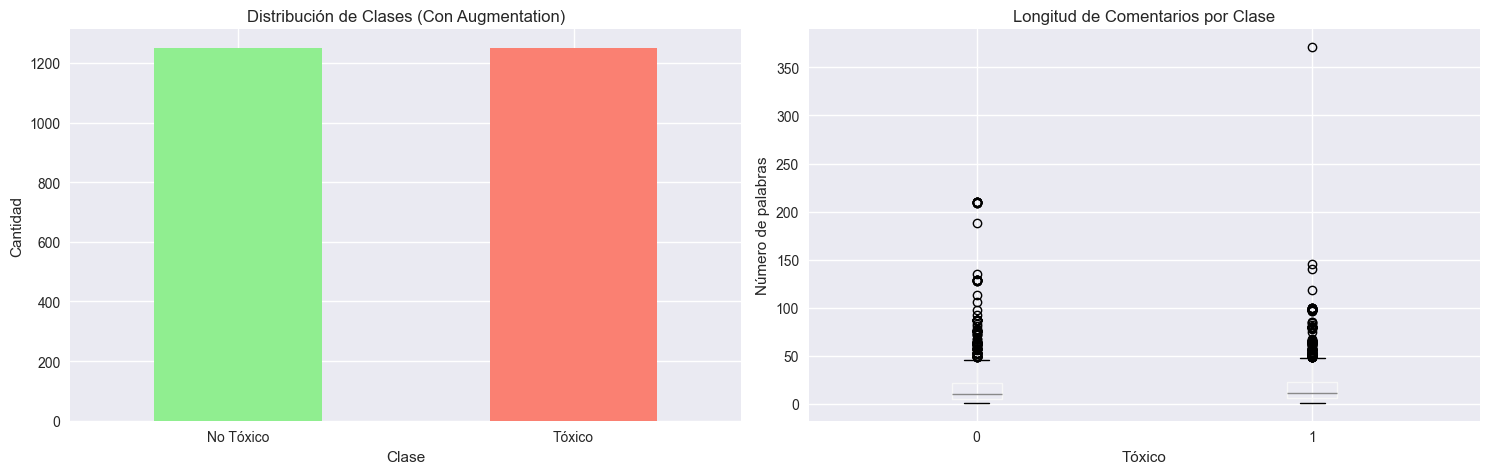

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Balance de clases
df_final['toxic_binary'].value_counts().plot(kind='bar', ax=axes[0], 
                                            color=['lightgreen', 'salmon'])
axes[0].set_title('Distribución de Clases (Con Augmentation)')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')
axes[0].set_xticklabels(['No Tóxico', 'Tóxico'], rotation=0)

# Longitud de comentarios
df_final['longitud'] = df_final['texto_procesado'].str.split().str.len()
df_final.boxplot(column='longitud', by='toxic_binary', ax=axes[1])
axes[1].set_title('Longitud de Comentarios por Clase')
axes[1].set_xlabel('Tóxico')
axes[1].set_ylabel('Número de palabras')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Wordclouds comparativos


📊 WORDCLOUDS COMPARATIVOS
   • Comentarios tóxicos para WordCloud: 1250
   • Comentarios no tóxicos para WordCloud: 1250
   • Palabras en corpus tóxico: 23543
   • Palabras en corpus no tóxico: 23957


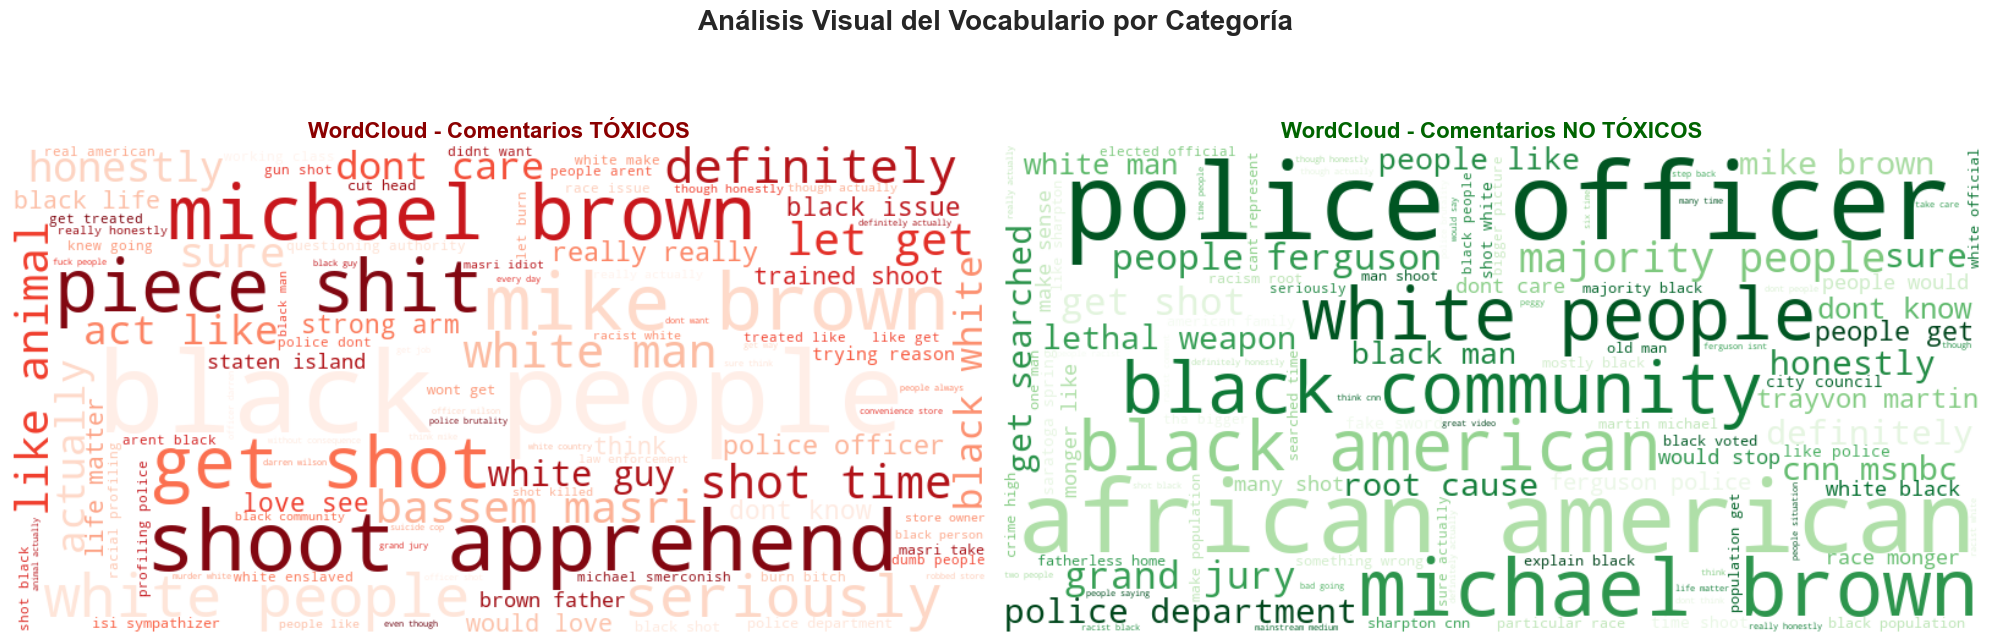

In [24]:
print("\n📊 WORDCLOUDS COMPARATIVOS")

# Separar textos por categoría usando los datos procesados
textos_toxicos = df_final[df_final['toxic_binary'] == 1]['texto_procesado']
textos_no_toxicos = df_final[df_final['toxic_binary'] == 0]['texto_procesado']

print(f"   • Comentarios tóxicos para WordCloud: {len(textos_toxicos)}")
print(f"   • Comentarios no tóxicos para WordCloud: {len(textos_no_toxicos)}")

# Combinar textos por categoría
texto_toxico_combinado = ' '.join(textos_toxicos.dropna())
texto_no_toxico_combinado = ' '.join(textos_no_toxicos.dropna())

print(f"   • Palabras en corpus tóxico: {len(texto_toxico_combinado.split())}")
print(f"   • Palabras en corpus no tóxico: {len(texto_no_toxico_combinado.split())}")

# Verificar que tenemos suficiente texto
if len(texto_toxico_combinado.split()) < 10:
    print("⚠️ Advertencia: Poco texto tóxico disponible para WordCloud")
if len(texto_no_toxico_combinado.split()) < 10:
    print("⚠️ Advertencia: Poco texto no tóxico disponible para WordCloud")

# Generar WordClouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Configuración común para ambos WordClouds
wordcloud_config = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'max_words': 100,
    'relative_scaling': 0.5,
    'stopwords': stop_words,  # Usar las mismas stopwords del preprocesamiento
    'collocation_threshold': 10
}

# WordCloud para comentarios tóxicos
if len(texto_toxico_combinado.strip()) > 0:
    wordcloud_toxico = WordCloud(
        **wordcloud_config,
        colormap='Reds'
    ).generate(texto_toxico_combinado)
    
    axes[0].imshow(wordcloud_toxico, interpolation='bilinear')
    axes[0].set_title('WordCloud - Comentarios TÓXICOS', fontweight='bold', fontsize=16, color='darkred')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'No hay suficiente\ntexto tóxico', 
                ha='center', va='center', transform=axes[0].transAxes, fontsize=16)
    axes[0].set_title('WordCloud - Comentarios TÓXICOS', fontweight='bold', fontsize=16, color='darkred')

# WordCloud para comentarios no tóxicos
if len(texto_no_toxico_combinado.strip()) > 0:
    wordcloud_no_toxico = WordCloud(
        **wordcloud_config,
        colormap='Greens'
    ).generate(texto_no_toxico_combinado)
    
    axes[1].imshow(wordcloud_no_toxico, interpolation='bilinear')
    axes[1].set_title('WordCloud - Comentarios NO TÓXICOS', fontweight='bold', fontsize=16, color='darkgreen')
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'No hay suficiente\ntexto no tóxico', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=16)
    axes[1].set_title('WordCloud - Comentarios NO TÓXICOS', fontweight='bold', fontsize=16, color='darkgreen')

plt.suptitle('Análisis Visual del Vocabulario por Categoría', fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# 8. Preparación para machine learning

In [25]:
print("\n🎯 Preparando datos para entrenamiento...")

# Features y target
X = df_final['texto_procesado']
y = df_final['toxic_binary']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 División de datos:")
print(f"   - Entrenamiento: {len(X_train)} ({y_train.mean()*100:.1f}% tóxicos)")
print(f"   - Prueba: {len(X_test)} ({y_test.mean()*100:.1f}% tóxicos)")


🎯 Preparando datos para entrenamiento...
📊 División de datos:
   - Entrenamiento: 2000 (50.0% tóxicos)
   - Prueba: 500 (50.0% tóxicos)


# 9. Vectorización optimizada

In [26]:
print("\n🔢 Vectorizando con TF-IDF...")

vectorizer = TfidfVectorizer(
    max_features=2000,      # Más features por más datos
    ngram_range=(1, 3),     # Incluir trigramas
    min_df=2,               # Mínima frecuencia
    max_df=0.95,            # Máxima frecuencia
    sublinear_tf=True,      # Escalado logarítmico
    use_idf=True,           # IDF para ponderar importancia
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"✅ Forma de datos vectorizados: {X_train_vec.shape}")


🔢 Vectorizando con TF-IDF...
✅ Forma de datos vectorizados: (2000, 2000)


# 10. Entrenamiento de XGBoost

In [27]:
print("\n🚀 Entrenando XGBoost optimizado...")

# Calcular peso de clases para balanceo
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Modelo XGBoost con hiperparámetros optimizados
modelo = xgb.XGBClassifier(
    # Parámetros básicos
    n_estimators=300,           # Número de árboles
    max_depth=6,                # Profundidad máxima
    learning_rate=0.1,          # Tasa de aprendizaje
    
    # Control de overfitting
    subsample=0.8,              # Submuestreo de filas
    colsample_bytree=0.8,       # Submuestreo de columnas
    reg_alpha=0.1,              # Regularización L1
    reg_lambda=1.0,             # Regularización L2
    
    # Balanceo de clases
    scale_pos_weight=scale_pos_weight,
    
    # Otros parámetros
    objective='binary:logistic',
    eval_metric=['error', 'logloss'],  # Métricas de evaluación
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,                  # Usar todos los cores
    early_stopping_rounds=20    # Early stopping
)

# Entrenar con conjunto de validación
eval_set = [(X_train_vec, y_train), (X_test_vec, y_test)]
modelo.fit(
    X_train_vec, y_train,
    eval_set=eval_set,
    verbose=False
)

# Obtener información del entrenamiento
resultado_entrenamiento = modelo.evals_result()
if resultado_entrenamiento:
    # Obtener el mejor score de la validación
    val_scores = resultado_entrenamiento['validation_1']['logloss']
    mejor_iteracion = np.argmin(val_scores)
    mejor_score = val_scores[mejor_iteracion]
    print(f"✅ Mejor iteración: {mejor_iteracion + 1}")
    print(f"✅ Mejor score (logloss): {mejor_score:.4f}")

# Validación cruzada con modelo sin early stopping
print("\n📈 Realizando validación cruzada...")
modelo_cv = xgb.XGBClassifier(
    n_estimators=100,  # Menos árboles para CV rápida
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

scores_cv = cross_val_score(modelo_cv, X_train_vec, y_train, cv=5, scoring='f1')
print(f"   - F1-Scores: {[f'{s:.3f}' for s in scores_cv]}")
print(f"   - Media: {scores_cv.mean():.3f} (+/- {scores_cv.std() * 2:.3f})")


🚀 Entrenando XGBoost optimizado...
✅ Mejor iteración: 300
✅ Mejor score (logloss): 0.2379

📈 Realizando validación cruzada...
   - F1-Scores: ['0.899', '0.886', '0.866', '0.858', '0.852']
   - Media: 0.872 (+/- 0.036)


# 11. Evaluación detallada


📊 EVALUACIÓN EN CONJUNTO DE PRUEBA:

🎯 Métricas principales:
   - Accuracy: 0.910
   - F1-Score: 0.908

📋 Reporte de clasificación:
              precision    recall  f1-score   support

   No Tóxico      0.896     0.928     0.912       250
      Tóxico      0.925     0.892     0.908       250

    accuracy                          0.910       500
   macro avg      0.911     0.910     0.910       500
weighted avg      0.911     0.910     0.910       500



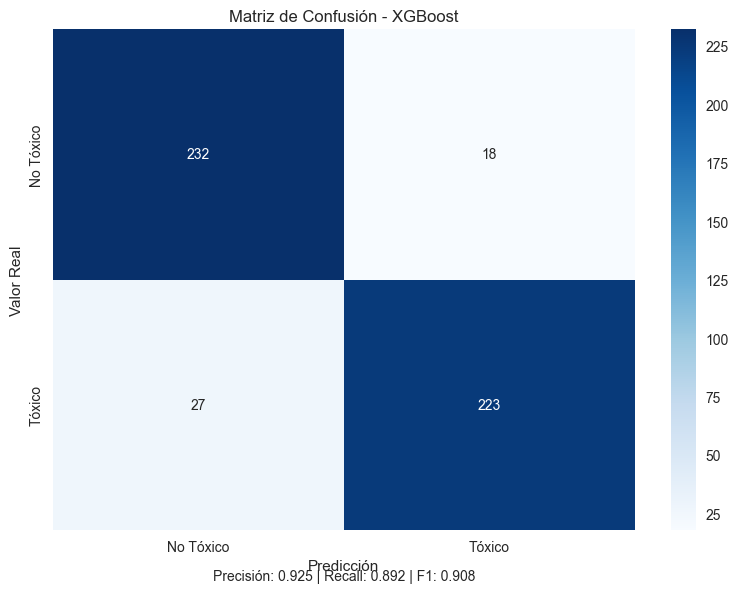

In [28]:
print("\n📊 EVALUACIÓN EN CONJUNTO DE PRUEBA:")

# Predicciones
y_pred = modelo.predict(X_test_vec)
y_pred_proba = modelo.predict_proba(X_test_vec)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n🎯 Métricas principales:")
print(f"   - Accuracy: {accuracy:.3f}")
print(f"   - F1-Score: {f1:.3f}")

# Reporte completo
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Tóxico', 'Tóxico'],
                          digits=3))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tóxico', 'Tóxico'],
            yticklabels=['No Tóxico', 'Tóxico'])
plt.title('Matriz de Confusión - XGBoost')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')

# Agregar métricas en el título
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
plt.text(0.5, -0.1, f'Precisión: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}', 
         ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 12. Análisis de importancia de features


🔤 ANÁLISIS DE IMPORTANCIA DE FEATURES:

🏆 Top 20 features más importantes:
   'black people': 0.0152
   'idiot': 0.0151
   'thug': 0.0145
   'fuck': 0.0129
   'african american': 0.0126
   'way': 0.0121
   'bitch': 0.0120
   'killed': 0.0120
   'shit': 0.0119
   'started': 0.0111
   'shoot apprehend': 0.0108
   'hell': 0.0104
   'ferguson': 0.0102
   'absolutely': 0.0101
   'isi': 0.0100
   'riot': 0.0099
   'terrorist': 0.0096
   'cnn': 0.0094
   'head': 0.0087
   'since': 0.0086


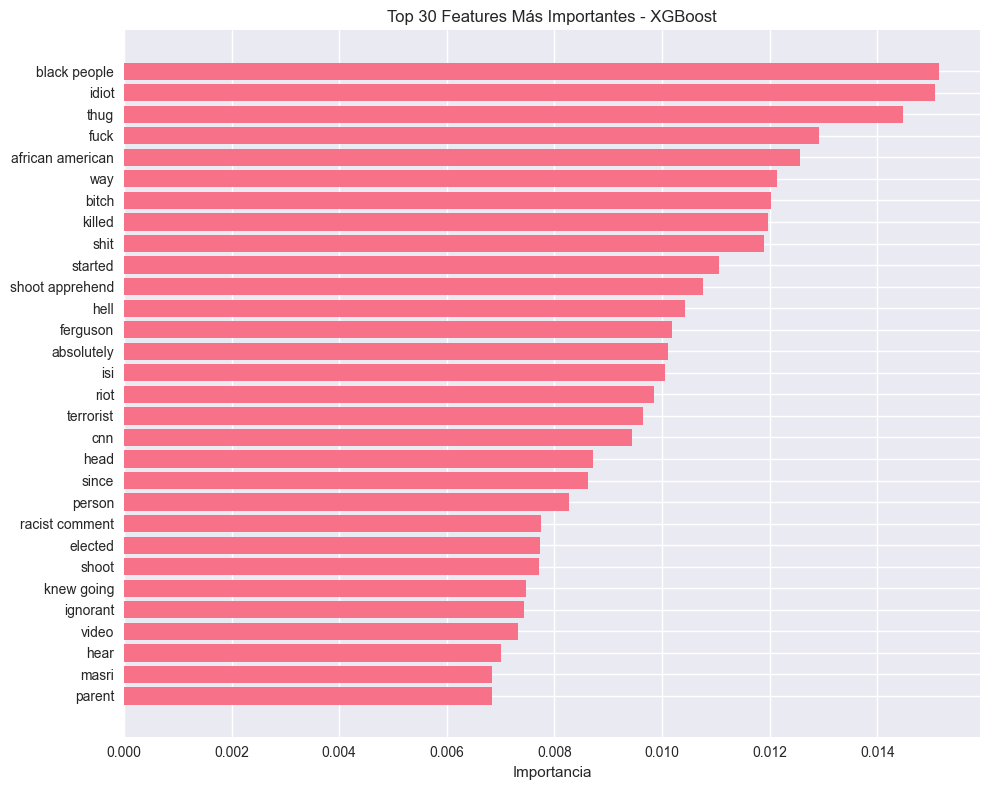


📊 Análisis detallado de importancia:

WEIGHT:
   'people': 64.0000
   'cop': 53.0000
   'shot': 52.0000
   'cnn': 49.0000
   'guy': 48.0000
   'black': 45.0000
   'one': 45.0000
   'like': 39.0000
   'need': 35.0000
   'fuck': 33.0000

GAIN:
   'black people': 13.9255
   'idiot': 13.8562
   'thug': 13.2998
   'fuck': 11.8652
   'african american': 11.5413
   'way': 11.1611
   'bitch': 11.0551
   'killed': 11.0061
   'shit': 10.9287
   'started': 10.1709

COVER:
   'shoot apprehend': 324.5141
   'hell': 311.7867
   'terrorist': 280.9038
   'started': 280.5435
   'since': 271.3582
   'idiot': 268.2932
   'way': 261.3682
   'thug': 261.1257
   'ignorant': 257.7142
   'knew going': 257.1833


In [29]:
print("\n🔤 ANÁLISIS DE IMPORTANCIA DE FEATURES:")

# Obtener importancia de features de XGBoost
feature_names = vectorizer.get_feature_names_out()
importancias = modelo.feature_importances_

# Crear DataFrame de importancias
df_importancia = pd.DataFrame({
    'feature': feature_names,
    'importance': importancias
}).sort_values('importance', ascending=False)

# Top 20 features más importantes
print("\n🏆 Top 20 features más importantes:")
for idx, row in df_importancia.head(20).iterrows():
    print(f"   '{row['feature']}': {row['importance']:.4f}")

# Visualizar importancia de features
plt.figure(figsize=(10, 8))
top_features = df_importancia.head(30)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 30 Features Más Importantes - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Análisis adicional: Gain vs Cover
if hasattr(modelo, 'get_booster'):
    print("\n📊 Análisis detallado de importancia:")
    importance_types = ['weight', 'gain', 'cover']
    
    for imp_type in importance_types:
        importances_dict = modelo.get_booster().get_score(importance_type=imp_type)
        if importances_dict:
            print(f"\n{imp_type.upper()}:")
            sorted_imp = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)[:10]
            for feat, score in sorted_imp:
                if feat.startswith('f'):
                    feat_idx = int(feat[1:])
                    feat_name = feature_names[feat_idx]
                    print(f"   '{feat_name}': {score:.4f}")

# 13. Función de predicción

In [30]:
def predecir_toxicidad(texto, modelo=modelo, vectorizer=vectorizer):
    """
    Predice si un comentario es tóxico.
    
    Retorna:
    - etiqueta: 'TÓXICO' o 'NO TÓXICO'
    - confianza: probabilidad de la predicción
    """
    # Preprocesar
    texto_limpio = limpiar_texto(texto)
    texto_procesado = procesar_texto(texto_limpio)
    
    # Vectorizar
    texto_vec = vectorizer.transform([texto_procesado])
    
    # Predecir
    prediccion = modelo.predict(texto_vec)[0]
    probabilidad = modelo.predict_proba(texto_vec)[0, 1]
    
    etiqueta = "TÓXICO ⚠️" if prediccion == 1 else "NO TÓXICO ✅"
    confianza = probabilidad if prediccion == 1 else (1 - probabilidad)
    
    return etiqueta, confianza

# Probar con ejemplos
print("\n🧪 PRUEBAS CON COMENTARIOS NUEVOS:")

ejemplos = [
    "Great video, thanks for sharing!",
    "You're so stupid and ignorant",
    "I disagree with your opinion",
    "This is garbage content, delete it",
    "Interesting perspective, never thought about it that way"
]

for comentario in ejemplos:
    etiqueta, confianza = predecir_toxicidad(comentario)
    print(f"\n📝 '{comentario}'")
    print(f"   → {etiqueta} (Confianza: {confianza:.1%})")


🧪 PRUEBAS CON COMENTARIOS NUEVOS:

📝 'Great video, thanks for sharing!'
   → NO TÓXICO ✅ (Confianza: 95.4%)

📝 'You're so stupid and ignorant'
   → TÓXICO ⚠️ (Confianza: 74.0%)

📝 'I disagree with your opinion'
   → NO TÓXICO ✅ (Confianza: 71.8%)

📝 'This is garbage content, delete it'
   → NO TÓXICO ✅ (Confianza: 71.8%)

📝 'Interesting perspective, never thought about it that way'
   → NO TÓXICO ✅ (Confianza: 73.0%)


# 14. Análisis de overfitting


🔍 ANÁLISIS DE OVERFITTING

📊 COMPARACIÓN DE MÉTRICAS POR CONJUNTO:
----------------------------------------

Entrenamiento:
  ACCURACY: 0.9660
  PRECISION: 0.9895
  RECALL: 0.9420
  F1: 0.9652
  AUC: 0.9949

Prueba:
  ACCURACY: 0.9100
  PRECISION: 0.9253
  RECALL: 0.8920
  F1: 0.9084
  AUC: 0.9700

🚨 DETECCIÓN DE OVERFITTING:
------------------------------
📈 F1 Train vs Test: 0.0568
⚠️  OVERFITTING MODERADO detectado (Train >> Test)

📊 GENERANDO VISUALIZACIONES...
📈 Calculando curvas de aprendizaje...


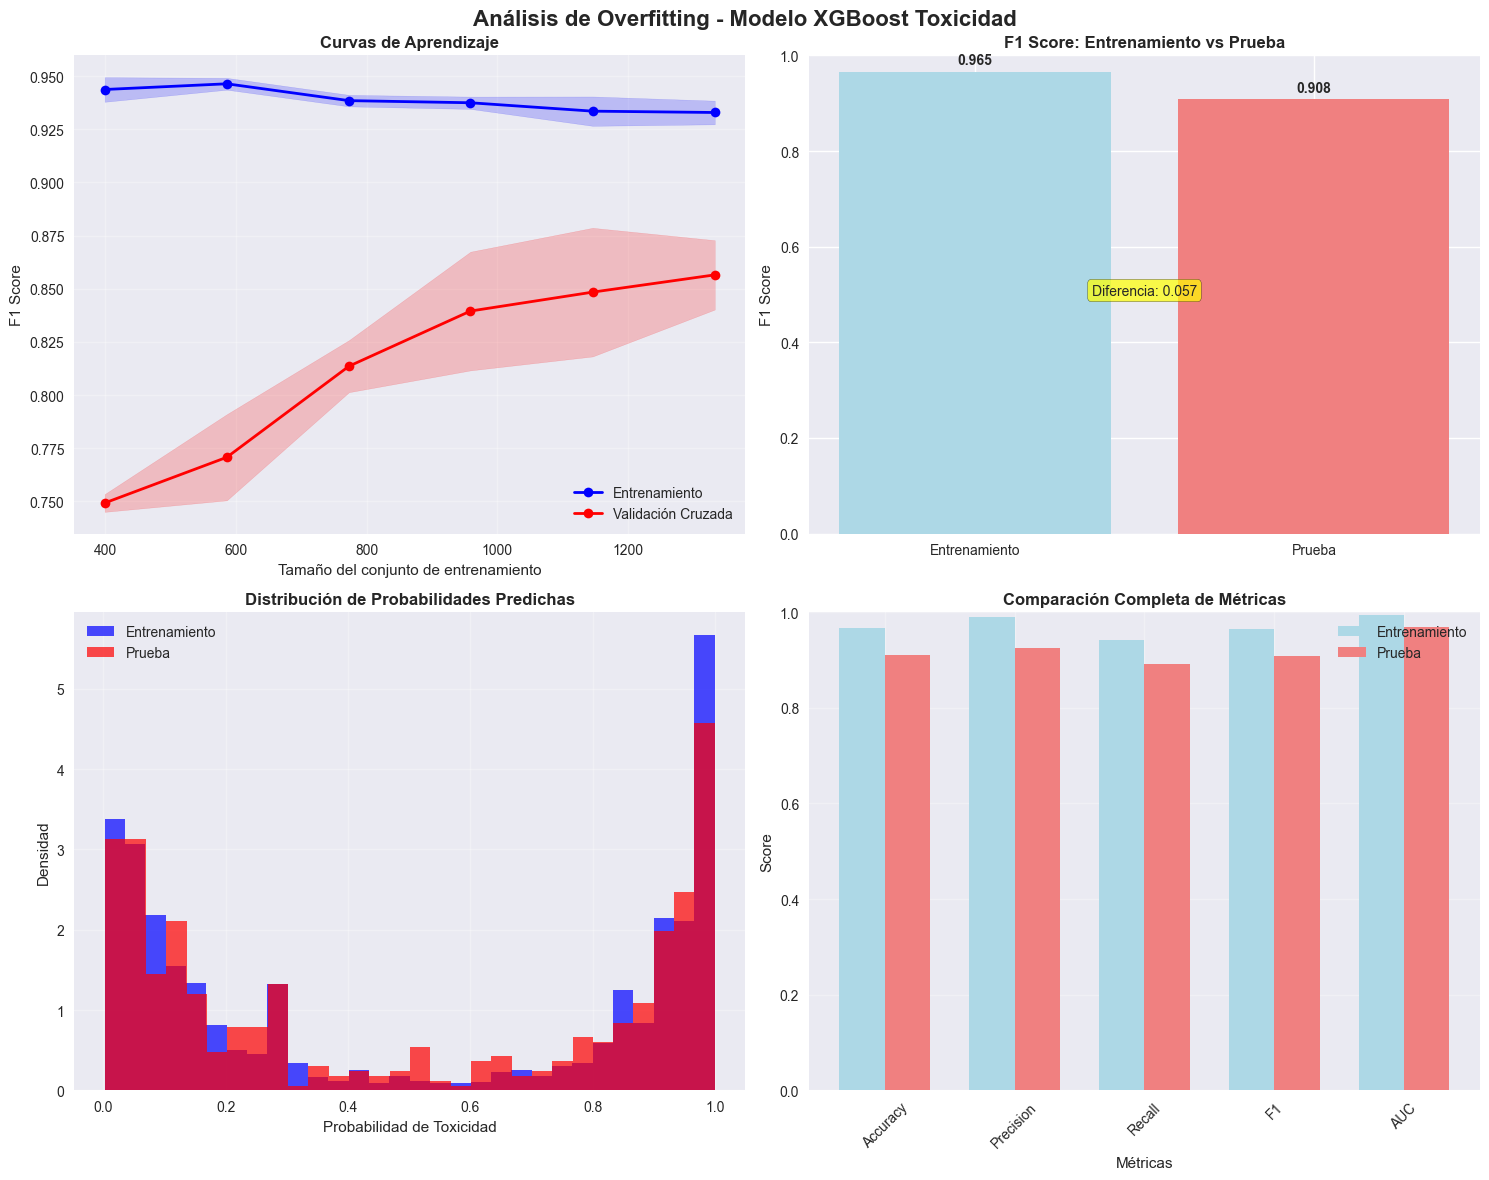


📋 REPORTE FINAL DE OVERFITTING
📊 ANÁLISIS DETALLADO:
   • F1 Entrenamiento: 0.9652
   • F1 Prueba:        0.9084

🔍 GAP DE RENDIMIENTO:
   • Train-Test gap:   0.0568

🩺 DIAGNÓSTICO:
   ⚠️  MODERADO: Overfitting detectado

💡 RECOMENDACIÓN:
   Considerar más regularización o early stopping más agresivo

🎯 CAPACIDAD DE GENERALIZACIÓN: 14.8/100 🟠
   👎 GENERALIZACIÓN BAJA - Hay overfitting, revisar modelo

🎯 ANÁLISIS ESPECÍFICO PARA TOXICIDAD:
   • Gap Precision: 0.0642
   • Gap Recall:    0.0500

✅ ANÁLISIS DE OVERFITTING COMPLETADO

📈 ANÁLISIS ADICIONAL: DISTRIBUCIÓN DE CONFIANZA
--------------------------------------------------
📊 Distribución de confianza en predicciones de prueba:
   • Alta confianza (>80% o <20%):  382 (76.4%)
   • Media confianza (60-80%, 20-40%):  95 (19.0%)
   • Baja confianza (40-60%):        23 (4.6%)

🎯 Accuracy por nivel de confianza:
   • Alta confianza: 0.971
   • Media confianza: 0.737
   • Baja confianza: 0.609

💡 Interpretación:
   ✅ Modelo hace prediccio

In [15]:
def analizar_overfitting(modelo_xgb, X_train_vec, y_train, X_test_vec, y_test):
    """
    Análisis completo de overfitting del modelo XGBoost
    Adaptado para el notebook de detección de toxicidad
    """
    
    print("🔍 ANÁLISIS DE OVERFITTING")
    print("=" * 50)
    
    # 1. MÉTRICAS COMPARATIVAS ENTRE CONJUNTOS
    print("\n📊 COMPARACIÓN DE MÉTRICAS POR CONJUNTO:")
    print("-" * 40)
    
    conjuntos_datos = {
        'Entrenamiento': (X_train_vec, y_train),
        'Prueba': (X_test_vec, y_test)
    }
    
    comparacion_metricas = {}
    
    for nombre, (X, y) in conjuntos_datos.items():
        y_pred = modelo_xgb.predict(X)
        y_proba = modelo_xgb.predict_proba(X)[:, 1]
        
        metricas = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'auc': roc_auc_score(y, y_proba)
        }
        
        comparacion_metricas[nombre] = metricas
        
        print(f"\n{nombre}:")
        for metrica, valor in metricas.items():
            print(f"  {metrica.upper()}: {valor:.4f}")
    
    # 2. DETECTAR OVERFITTING
    print(f"\n🚨 DETECCIÓN DE OVERFITTING:")
    print("-" * 30)
    
    train_f1 = comparacion_metricas['Entrenamiento']['f1']
    test_f1 = comparacion_metricas['Prueba']['f1']
    
    # Diferencias
    train_test_diff = train_f1 - test_f1
    
    print(f"📈 F1 Train vs Test: {train_test_diff:.4f}")
    
    # Análisis de overfitting
    overfitting_detectado = False
    
    if train_test_diff > 0.08:  # Más de 8% de diferencia es preocupante
        print("❌ OVERFITTING SEVERO detectado (Train >> Test)")
        overfitting_detectado = True
    elif train_test_diff > 0.05:  # Más de 5% de diferencia
        print("⚠️  OVERFITTING MODERADO detectado (Train >> Test)")
        overfitting_detectado = True
    elif train_test_diff > 0.02:  # Ligero overfitting
        print("⚠️  LIGERO OVERFITTING detectado")
        overfitting_detectado = True
    
    if not overfitting_detectado:
        print("✅ NO se detecta overfitting significativo")
        print("✅ Modelo tiene buena generalización")
    
    return comparacion_metricas

def graficar_analisis_overfitting(modelo_xgb, X_train_vec, y_train, X_test_vec, y_test, comparacion_metricas):
    """
    Visualizaciones para análisis de overfitting
    Adaptado para el modelo XGBoost del notebook
    """
    
    print(f"\n📊 GENERANDO VISUALIZACIONES...")
    
    # Crear subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análisis de Overfitting - Modelo XGBoost Toxicidad', fontsize=16, fontweight='bold')
    
    # Subplot 1: Curvas de aprendizaje
    print("📈 Calculando curvas de aprendizaje...")
    
    # Crear un modelo XGBoost sin early stopping para las curvas de aprendizaje
    modelo_sin_early_stopping = xgb.XGBClassifier(
        n_estimators=100,  # Menos árboles para ser más rápido
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )
    
    train_sizes, train_scores, val_scores = learning_curve(
        modelo_sin_early_stopping, X_train_vec, y_train,
        cv=3, 
        train_sizes=np.linspace(0.3, 1.0, 6),  # Empezar con más datos para evitar problemas
        scoring='f1',
        n_jobs=-1
    )
    
    # Calcular medias y desviaciones
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[0, 0].plot(train_sizes, train_mean, 'o-', color='blue', label='Entrenamiento', linewidth=2)
    axes[0, 0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    
    axes[0, 0].plot(train_sizes, val_mean, 'o-', color='red', label='Validación Cruzada', linewidth=2)
    axes[0, 0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    axes[0, 0].set_xlabel('Tamaño del conjunto de entrenamiento')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_title('Curvas de Aprendizaje', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Subplot 2: Comparación de métricas Train vs Test
    conjuntos = ['Entrenamiento', 'Prueba']
    f1_scores = [
        comparacion_metricas['Entrenamiento']['f1'],
        comparacion_metricas['Prueba']['f1']
    ]
    
    colores = ['lightblue', 'lightcoral']
    barras = axes[0, 1].bar(conjuntos, f1_scores, color=colores)
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('F1 Score: Entrenamiento vs Prueba', fontweight='bold')
    axes[0, 1].set_ylim(0, 1)
    
    # Añadir valores en las barras
    for barra, score in zip(barras, f1_scores):
        axes[0, 1].text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.01,
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Línea de referencia para mostrar la diferencia
    diferencia = abs(f1_scores[0] - f1_scores[1])
    axes[0, 1].text(0.5, 0.5, f'Diferencia: {diferencia:.3f}', 
                   transform=axes[0, 1].transAxes, ha='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Subplot 3: Distribución de probabilidades por conjunto
    y_proba_train = modelo_xgb.predict_proba(X_train_vec)[:, 1]
    y_proba_test = modelo_xgb.predict_proba(X_test_vec)[:, 1]
    
    axes[1, 0].hist(y_proba_train, bins=30, alpha=0.7, label='Entrenamiento', color='blue', density=True)
    axes[1, 0].hist(y_proba_test, bins=30, alpha=0.7, label='Prueba', color='red', density=True)
    axes[1, 0].set_xlabel('Probabilidad de Toxicidad')
    axes[1, 0].set_ylabel('Densidad')
    axes[1, 0].set_title('Distribución de Probabilidades Predichas', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Subplot 4: Todas las métricas comparadas
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    train_metricas = [comparacion_metricas['Entrenamiento'][m.lower()] for m in metricas]
    test_metricas = [comparacion_metricas['Prueba'][m.lower()] for m in metricas]
    
    x = np.arange(len(metricas))
    ancho = 0.35
    
    axes[1, 1].bar(x - ancho/2, train_metricas, ancho, label='Entrenamiento', color='lightblue')
    axes[1, 1].bar(x + ancho/2, test_metricas, ancho, label='Prueba', color='lightcoral')
    
    axes[1, 1].set_xlabel('Métricas')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Comparación Completa de Métricas', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metricas, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def generar_reporte_overfitting(comparacion_metricas):
    """
    Generar reporte final de overfitting
    """
    
    print(f"\n📋 REPORTE FINAL DE OVERFITTING")
    print("=" * 50)
    
    train_f1 = comparacion_metricas['Entrenamiento']['f1']
    test_f1 = comparacion_metricas['Prueba']['f1']
    
    # Análisis detallado
    print(f"📊 ANÁLISIS DETALLADO:")
    print(f"   • F1 Entrenamiento: {train_f1:.4f}")
    print(f"   • F1 Prueba:        {test_f1:.4f}")
    
    gap_train_test = train_f1 - test_f1
    
    print(f"\n🔍 GAP DE RENDIMIENTO:")
    print(f"   • Train-Test gap:   {gap_train_test:.4f}")
    
    # Diagnóstico
    print(f"\n🩺 DIAGNÓSTICO:")
    
    if gap_train_test < 0.02:
        print("   ✅ EXCELENTE: Modelo muy bien generalizado")
        recomendacion = "El modelo está listo para producción"
        color_estado = "🟢"
        
    elif gap_train_test < 0.05:
        print("   ✅ BUENO: Ligero overfitting, pero aceptable")
        recomendacion = "Modelo aceptable para producción con monitoreo"
        color_estado = "🟡"
        
    elif gap_train_test < 0.08:
        print("   ⚠️  MODERADO: Overfitting detectado")
        recomendacion = "Considerar más regularización o early stopping más agresivo"
        color_estado = "🟠"
        
    else:
        print("   ❌ SEVERO: Overfitting significativo")
        recomendacion = "Necesario ajustar hiperparámetros o reentrenar"
        color_estado = "🔴"
    
    print(f"\n💡 RECOMENDACIÓN:")
    print(f"   {recomendacion}")
    
    # Métricas de generalización (no "confianza" para evitar confusión)
    puntaje_generalizacion = max(0, 100 - (gap_train_test * 100 * 15))
    print(f"\n🎯 CAPACIDAD DE GENERALIZACIÓN: {puntaje_generalizacion:.1f}/100 {color_estado}")
    
    if puntaje_generalizacion >= 85:
        print("   🏆 EXCELENTE generalización - Modelo muy robusto")
    elif puntaje_generalizacion >= 70:
        print("   👍 BUENA generalización - Modelo confiable")
    elif puntaje_generalizacion >= 50:
        print("   ⚠️  GENERALIZACIÓN MEDIA - Modelo aceptable con reservas")
    else:
        print("   👎 GENERALIZACIÓN BAJA - Hay overfitting, revisar modelo")
    
    # Análisis adicional específico para detección de toxicidad
    print(f"\n🎯 ANÁLISIS ESPECÍFICO PARA TOXICIDAD:")
    
    train_precision = comparacion_metricas['Entrenamiento']['precision']
    test_precision = comparacion_metricas['Prueba']['precision']
    precision_gap = train_precision - test_precision
    
    train_recall = comparacion_metricas['Entrenamiento']['recall']
    test_recall = comparacion_metricas['Prueba']['recall']
    recall_gap = train_recall - test_recall
    
    print(f"   • Gap Precision: {precision_gap:.4f}")
    print(f"   • Gap Recall:    {recall_gap:.4f}")
    
    if precision_gap > 0.1:
        print("   ⚠️  Modelo podría estar generando muchos falsos positivos en producción")
    if recall_gap > 0.1:
        print("   ⚠️  Modelo podría estar perdiendo comentarios tóxicos en producción")

# EJECUTAR ANÁLISIS COMPLETO DE OVERFITTING
# 1. Analizar overfitting con las métricas
comparacion_metricas = analizar_overfitting(
    modelo, X_train_vec, y_train, X_test_vec, y_test
)

# 2. Generar visualizaciones
graficar_analisis_overfitting(
    modelo, X_train_vec, y_train, X_test_vec, y_test, comparacion_metricas
)

# 3. Generar reporte final
generar_reporte_overfitting(comparacion_metricas)

print(f"\n✅ ANÁLISIS DE OVERFITTING COMPLETADO")
print("="*70)

# ANÁLISIS ADICIONAL: PREDICCIONES POR CONFIANZA
print(f"\n📈 ANÁLISIS ADICIONAL: DISTRIBUCIÓN DE CONFIANZA")
print("-" * 50)

# Analizar las predicciones por nivel de confianza
y_proba_test = modelo.predict_proba(X_test_vec)[:, 1]

# Categorizar predicciones por confianza
alta_confianza = (y_proba_test >= 0.8) | (y_proba_test <= 0.2)
media_confianza = ((y_proba_test >= 0.6) & (y_proba_test < 0.8)) | ((y_proba_test > 0.2) & (y_proba_test <= 0.4))
baja_confianza = (y_proba_test > 0.4) & (y_proba_test < 0.6)

print(f"📊 Distribución de confianza en predicciones de prueba:")
print(f"   • Alta confianza (>80% o <20%):  {alta_confianza.sum():3d} ({alta_confianza.mean()*100:.1f}%)")
print(f"   • Media confianza (60-80%, 20-40%): {media_confianza.sum():3d} ({media_confianza.mean()*100:.1f}%)")
print(f"   • Baja confianza (40-60%):       {baja_confianza.sum():3d} ({baja_confianza.mean()*100:.1f}%)")

# Calcular accuracy por nivel de confianza
if alta_confianza.sum() > 0:
    acc_alta = accuracy_score(y_test[alta_confianza], (y_proba_test[alta_confianza] > 0.5))
    print(f"\n🎯 Accuracy por nivel de confianza:")
    print(f"   • Alta confianza: {acc_alta:.3f}")

if media_confianza.sum() > 0:
    acc_media = accuracy_score(y_test[media_confianza], (y_proba_test[media_confianza] > 0.5))
    print(f"   • Media confianza: {acc_media:.3f}")

if baja_confianza.sum() > 0:
    acc_baja = accuracy_score(y_test[baja_confianza], (y_proba_test[baja_confianza] > 0.5))
    print(f"   • Baja confianza: {acc_baja:.3f}")

print(f"\n💡 Interpretación:")
if baja_confianza.mean() < 0.15:  # Menos del 15% de predicciones inciertas
    print("   ✅ Modelo hace predicciones con alta certeza individual")
    print("   📊 La mayoría de predicciones son muy seguras (>80% o <20%)")
else:
    print("   ⚠️  Considerable número de predicciones con baja certeza")
    print("   📊 Muchas predicciones están en zona gris (40-60%)")

print(f"\n🏁 ANÁLISIS COMPLETO FINALIZADO")
print("="*70)

# 15. Optimización con Optuna

In [16]:
def objective(trial):
    """Función objetivo para optimizar hiperparámetros anti-overfitting"""
    try:
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 5.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'objective': 'binary:logistic',
            'eval_metric': ['error', 'logloss'],  
            'use_label_encoder': False,  
            'random_state': 42,
            'n_jobs': 1,  # Usar 1 core para evitar conflictos en CV
            'scale_pos_weight': scale_pos_weight,
            'verbosity': 0
        }
        
        # Modelo para validación cruzada
        modelo_cv = xgb.XGBClassifier(**params)
        
        # Validación cruzada
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  
        f1_scores = cross_val_score(
            modelo_cv, X_train_vec, y_train, 
            cv=cv, scoring='f1', error_score='raise'
        )
        
        modelo_test = xgb.XGBClassifier(**params)
        modelo_test.fit(X_train_vec, y_train)
        
        train_f1 = f1_score(y_train, modelo_test.predict(X_train_vec))
        test_f1 = f1_score(y_test, modelo_test.predict(X_test_vec))
        overfitting_gap = abs(train_f1 - test_f1)
        
        train_pred_proba = modelo_test.predict_proba(X_train_vec)[:, 1]
        test_pred_proba = modelo_test.predict_proba(X_test_vec)[:, 1]
        
        from sklearn.metrics import log_loss
        train_logloss = log_loss(y_train, train_pred_proba)
        test_logloss = log_loss(y_test, test_pred_proba)
        logloss_gap = abs(train_logloss - test_logloss)
        
        # Guardar métricas
        trial.set_user_attr('cv_f1', f1_scores.mean())
        trial.set_user_attr('cv_f1_std', f1_scores.std())
        trial.set_user_attr('train_f1', train_f1)
        trial.set_user_attr('test_f1', test_f1)
        trial.set_user_attr('overfitting_gap', overfitting_gap)
        trial.set_user_attr('train_logloss', train_logloss)
        trial.set_user_attr('test_logloss', test_logloss)
        trial.set_user_attr('logloss_gap', logloss_gap)
        
        # Optimiza F1 pero penaliza overfitting en ambas métricas
        penalty = (overfitting_gap * 1.0) + (logloss_gap * 0.5)
        return f1_scores.mean() - penalty
        
    except Exception as e:
        print(f"Error en trial: {e}")
        return -1.0  # Score muy bajo para trials fallidos

def optimizar_xgboost(X_train_vec, y_train, X_test_vec, y_test, n_trials=50):
    """Optimiza hiperparámetros usando Optuna"""
    # Hacer variables globales para objective
    globals().update({
        'X_train_vec': X_train_vec, 'y_train': y_train,
        'X_test_vec': X_test_vec, 'y_test': y_test
    })
    
    # Verificar que los datos sean válidos
    print(f"Datos de entrenamiento: {X_train_vec.shape}, {len(y_train)}")
    print(f"Datos de prueba: {X_test_vec.shape}, {len(y_test)}")
    print(f"Distribución y_train: {np.bincount(y_train)}")
    
    study = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Filtrar trials exitosos
    successful_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value > -0.5]
    
    if not successful_trials:
        raise ValueError("No se completaron trials exitosos. Revisa tus datos.")
    
    best_trial = max(successful_trials, key=lambda x: x.value)
    
    print(f"\nMejor score: {best_trial.value:.4f}")
    print(f"CV F1: {best_trial.user_attrs['cv_f1']:.4f} (±{best_trial.user_attrs['cv_f1_std']:.4f})")
    print(f"Train F1: {best_trial.user_attrs['train_f1']:.4f}")
    print(f"Test F1: {best_trial.user_attrs['test_f1']:.4f}")
    print(f"Gap overfitting F1: {best_trial.user_attrs['overfitting_gap']:.4f}")
    print(f"Train LogLoss: {best_trial.user_attrs['train_logloss']:.4f}")  # NUEVO
    print(f"Test LogLoss: {best_trial.user_attrs['test_logloss']:.4f}")    # NUEVO
    print(f"Gap overfitting LogLoss: {best_trial.user_attrs['logloss_gap']:.4f}")  # NUEVO
    print(f"Trials exitosos: {len(successful_trials)}/{len(study.trials)}")
    
    return best_trial.params

def entrenar_modelo_final(best_params, X_train_vec, y_train, X_test_vec, y_test):
    """Entrena modelo final con parámetros optimizados - VERSIÓN CORREGIDA"""
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    final_params = {
        **best_params,
        'objective': 'binary:logistic',
        'eval_metric': ['error', 'logloss'],  
        'use_label_encoder': False,           
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': scale_pos_weight,
        'verbosity': 0
    }
    
    modelo = xgb.XGBClassifier(**final_params)
    modelo.fit(X_train_vec, y_train)
    
    # Evaluación final
    train_pred = modelo.predict(X_train_vec)
    test_pred = modelo.predict(X_test_vec)
    
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    # Añadir evaluación de logloss
    train_pred_proba = modelo.predict_proba(X_train_vec)[:, 1]
    test_pred_proba = modelo.predict_proba(X_test_vec)[:, 1]
    
    from sklearn.metrics import log_loss
    train_logloss = log_loss(y_train, train_pred_proba)
    test_logloss = log_loss(y_test, test_pred_proba)
    
    # Validación cruzada final
    cv_scores = cross_val_score(
        xgb.XGBClassifier(**final_params), 
        X_train_vec, y_train, 
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
        scoring='f1'
    )
    
    print(f"\n✅ Modelo final:")
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print(f"CV F1: {cv_scores.mean():.3f} (±{cv_scores.std() * 2:.3f})")
    print(f"Overfitting gap F1: {abs(train_f1 - test_f1):.4f}")
    print(f"Train LogLoss: {train_logloss:.4f}")     
    print(f"Test LogLoss: {test_logloss:.4f}")      
    print(f"Overfitting gap LogLoss: {abs(train_logloss - test_logloss):.4f}") 
    
    return modelo, final_params

def optimizar_y_entrenar(X_train_vec, y_train, X_test_vec, y_test, n_trials=50):
    """Proceso completo de optimización y entrenamiento"""
    print("🚀 Optimizando XGBoost con Optuna...")
    
    # Verificaciones iniciales
    if len(np.unique(y_train)) != 2:
        raise ValueError("y_train debe ser binario (0 y 1)")
    
    if X_train_vec.shape[0] != len(y_train):
        raise ValueError("X_train_vec y y_train deben tener el mismo número de filas")
    
    best_params = optimizar_xgboost(X_train_vec, y_train, X_test_vec, y_test, n_trials)
    modelo_final, final_params = entrenar_modelo_final(best_params, X_train_vec, y_train, X_test_vec, y_test)
    
    return modelo_final, final_params

def guardar_modelos(modelo, vectorizer, nombre_base="modelo_toxicidad_xgboost"):
    """Guarda el modelo y vectorizer en archivos pickle"""
    import pickle
    
    # Nombres de archivos
    nombre_modelo = f"../final_model/{nombre_base}_final.pkl"
    nombre_vectorizer = f"../final_model/vectorizer_toxicidad_final.pkl"
    
    try:
        # Guardar modelo
        with open(nombre_modelo, 'wb') as f:
            pickle.dump(modelo, f)
        
        # Guardar vectorizer
        with open(nombre_vectorizer, 'wb') as f:
            pickle.dump(vectorizer, f)
        
        print(f"✅ Archivos guardados exitosamente:")
        print(f"   - {nombre_modelo}")
        print(f"   - {nombre_vectorizer}")
        
        return True
        
    except Exception as e:
        print(f"❌ Error al guardar archivos: {e}")
        return False

try:
    # Ejecutar optimización
    modelo_optimizado, params_optimizados = optimizar_y_entrenar(
        X_train_vec, y_train, X_test_vec, y_test, n_trials=60  
    )
    
    # Mostrar mejores parámetros
    print("\n🔧 MEJORES PARÁMETROS ENCONTRADOS:")
    for param, valor in params_optimizados.items():
        if param not in ['objective', 'eval_metric', 'use_label_encoder', 'random_state', 'n_jobs', 'scale_pos_weight', 'verbosity']:
            if isinstance(valor, float):
                print(f"   {param}: {valor:.4f}")
            else:
                print(f"   {param}: {valor}")
    
    print(f"\n🎯 Optimización completada exitosamente!")
    
    # Guardar modelos   
    if 'vectorizer' in globals():
        guardar_modelos(modelo_optimizado, vectorizer)
    else:
        print("⚠️  Advertencia: 'vectorizer' no está definido. Solo guardando el modelo.")
        import pickle
        with open('../final_model/modelo_toxicidad_xgboost_final.pkl', 'wb') as f:
            pickle.dump(modelo_optimizado, f)
        print("✅ Modelo guardado: ../final_model/modelo_toxicidad_xgboost_final.pkl")
    
except Exception as e:
    print(f"❌ Error durante la optimización: {e}")
    print("\n🔍 Verificando datos...")
    
    # Diagnóstico de datos
    print(f"Forma X_train_vec: {X_train_vec.shape if 'X_train_vec' in globals() else 'No definido'}")
    print(f"Forma y_train: {y_train.shape if 'y_train' in globals() else 'No definido'}")
    print(f"Forma X_test_vec: {X_test_vec.shape if 'X_test_vec' in globals() else 'No definido'}")
    print(f"Forma y_test: {y_test.shape if 'y_test' in globals() else 'No definido'}")
    
    if 'y_train' in globals():
        print(f"Valores únicos en y_train: {np.unique(y_train)}")
        print(f"Distribución y_train: {np.bincount(y_train)}")
    
    if 'X_train_vec' in globals():
        print(f"Tipo X_train_vec: {type(X_train_vec)}")
        print(f"¿Hay NaN en X_train_vec?: {np.isnan(X_train_vec).any() if hasattr(X_train_vec, 'shape') else 'No es array'}")
    
    print("\n💡 Sugerencias:")
    print("1. Asegúrate de que y_train e y_test contengan solo 0s y 1s")
    print("2. Verifica que no hay valores NaN en los datos")
    print("3. Confirma que X_train_vec y y_train tienen el mismo número de filas")

[I 2025-07-11 00:44:41,134] A new study created in memory with name: no-name-125da9fa-2a2b-4227-91eb-49e04f87f687


🚀 Optimizando XGBoost con Optuna...
Datos de entrenamiento: (2000, 2000), 2000
Datos de prueba: (500, 2000), 500
Distribución y_train: [1000 1000]


Best trial: 0. Best value: 0.660715:   2%|▏         | 1/60 [00:04<04:44,  4.82s/it]

[I 2025-07-11 00:44:45,953] Trial 0 finished with value: 0.6607147176187504 and parameters: {'n_estimators': 144, 'max_depth': 8, 'learning_rate': 0.22227824312530747, 'subsample': 0.8197316968394073, 'colsample_bytree': 0.7312037280884873, 'reg_alpha': 0.7884126564776512, 'reg_lambda': 0.29983722471931534, 'min_child_weight': 7}. Best is trial 0 with value: 0.6607147176187504.


Best trial: 1. Best value: 0.742554:   3%|▎         | 2/60 [00:15<08:00,  8.28s/it]

[I 2025-07-11 00:44:56,661] Trial 1 finished with value: 0.7425542520157196 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01596950334578271, 'subsample': 0.8939819704323989, 'colsample_bytree': 0.8664885281600844, 'reg_alpha': 1.0695721622845982, 'reg_lambda': 0.9173065863634321, 'min_child_weight': 2}. Best is trial 1 with value: 0.7425542520157196.


Best trial: 2. Best value: 0.745676:   5%|▌         | 3/60 [00:19<06:07,  6.44s/it]

[I 2025-07-11 00:45:00,918] Trial 2 finished with value: 0.745676237360833 and parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.13526405540621358, 'subsample': 0.7582458280396084, 'colsample_bytree': 0.8223705789444758, 'reg_alpha': 0.7060743646536888, 'reg_lambda': 1.4678017961907386, 'min_child_weight': 3}. Best is trial 2 with value: 0.745676237360833.


Best trial: 3. Best value: 0.764407:   7%|▋         | 4/60 [00:27<06:19,  6.77s/it]

[I 2025-07-11 00:45:08,186] Trial 3 finished with value: 0.7644067005250956 and parameters: {'n_estimators': 164, 'max_depth': 7, 'learning_rate': 0.06790539682592432, 'subsample': 0.8028468876827223, 'colsample_bytree': 0.8184829137724084, 'reg_alpha': 0.24178755947278865, 'reg_lambda': 3.0416488109881774, 'min_child_weight': 2}. Best is trial 3 with value: 0.7644067005250956.


Best trial: 3. Best value: 0.764407:   8%|▊         | 5/60 [00:29<04:56,  5.39s/it]

[I 2025-07-11 00:45:11,120] Trial 4 finished with value: 0.7422391436289665 and parameters: {'n_estimators': 66, 'max_depth': 8, 'learning_rate': 0.2900332895916222, 'subsample': 0.8616794696232922, 'colsample_bytree': 0.7609227538346741, 'reg_alpha': 0.49738384889185555, 'reg_lambda': 3.424322802295663, 'min_child_weight': 4}. Best is trial 3 with value: 0.7644067005250956.


Best trial: 3. Best value: 0.764407:  10%|█         | 6/60 [00:32<03:57,  4.39s/it]

[I 2025-07-11 00:45:13,581] Trial 5 finished with value: 0.6435705487158202 and parameters: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.019972671123413333, 'subsample': 0.8818640804157565, 'colsample_bytree': 0.7517559963200033, 'reg_alpha': 3.31598619892637, 'reg_lambda': 1.5654382696861608, 'min_child_weight': 4}. Best is trial 3 with value: 0.7644067005250956.


Best trial: 3. Best value: 0.764407:  12%|█▏        | 7/60 [00:36<03:50,  4.35s/it]

[I 2025-07-11 00:45:17,855] Trial 6 finished with value: 0.7063441127772742 and parameters: {'n_estimators': 187, 'max_depth': 4, 'learning_rate': 0.291179542051722, 'subsample': 0.8550265646722229, 'colsample_bytree': 0.8878997883128379, 'reg_alpha': 4.475188478633967, 'reg_lambda': 2.9935208942673146, 'min_child_weight': 7}. Best is trial 3 with value: 0.7644067005250956.


Best trial: 3. Best value: 0.764407:  13%|█▎        | 8/60 [00:38<03:09,  3.64s/it]

[I 2025-07-11 00:45:19,967] Trial 7 finished with value: 0.6173190726544824 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.023115913784056037, 'subsample': 0.7650660661526528, 'colsample_bytree': 0.7777354579378963, 'reg_alpha': 1.3640316685517406, 'reg_lambda': 4.145400170668127, 'min_child_weight': 3}. Best is trial 3 with value: 0.7644067005250956.


Best trial: 3. Best value: 0.764407:  15%|█▌        | 9/60 [00:44<03:31,  4.15s/it]

[I 2025-07-11 00:45:25,240] Trial 8 finished with value: 0.7292009725300043 and parameters: {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.050868025242681164, 'subsample': 0.8604393961508079, 'colsample_bytree': 0.7149101287359542, 'reg_alpha': 4.934565813636581, 'reg_lambda': 3.8635013987903206, 'min_child_weight': 2}. Best is trial 3 with value: 0.7644067005250956.


Best trial: 9. Best value: 0.785445:  17%|█▋        | 10/60 [00:47<03:16,  3.94s/it]

[I 2025-07-11 00:45:28,698] Trial 9 finished with value: 0.7854451129475323 and parameters: {'n_estimators': 51, 'max_depth': 7, 'learning_rate': 0.21498862971580895, 'subsample': 0.8458014336081975, 'colsample_bytree': 0.8542540693371892, 'reg_alpha': 0.3794828121531109, 'reg_lambda': 1.7987439854359204, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  18%|█▊        | 11/60 [00:53<03:49,  4.68s/it]

[I 2025-07-11 00:45:35,071] Trial 10 finished with value: 0.7721336578647098 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.19602204373030296, 'subsample': 0.7035923751229639, 'colsample_bytree': 0.8508276320352263, 'reg_alpha': 2.102197780118566, 'reg_lambda': 4.799256022267647, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  20%|██        | 12/60 [01:00<04:17,  5.36s/it]

[I 2025-07-11 00:45:41,971] Trial 11 finished with value: 0.770079504006378 and parameters: {'n_estimators': 287, 'max_depth': 3, 'learning_rate': 0.19077873239863388, 'subsample': 0.7034372300537918, 'colsample_bytree': 0.8561574793761311, 'reg_alpha': 2.177437796064492, 'reg_lambda': 4.790447646019391, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  22%|██▏       | 13/60 [01:07<04:31,  5.77s/it]

[I 2025-07-11 00:45:48,686] Trial 12 finished with value: 0.7576139833704567 and parameters: {'n_estimators': 261, 'max_depth': 3, 'learning_rate': 0.2180130891380103, 'subsample': 0.7013134243758604, 'colsample_bytree': 0.8397411932759423, 'reg_alpha': 2.0670774838831227, 'reg_lambda': 2.3488390422503334, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  23%|██▎       | 14/60 [01:14<04:42,  6.15s/it]

[I 2025-07-11 00:45:55,709] Trial 13 finished with value: 0.7128830808616693 and parameters: {'n_estimators': 238, 'max_depth': 5, 'learning_rate': 0.14957366296014662, 'subsample': 0.7454278023301757, 'colsample_bytree': 0.8954198325228144, 'reg_alpha': 3.3076700692085113, 'reg_lambda': 2.1962695357807607, 'min_child_weight': 6}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  25%|██▌       | 15/60 [01:25<05:47,  7.72s/it]

[I 2025-07-11 00:46:07,087] Trial 14 finished with value: 0.7580961000534581 and parameters: {'n_estimators': 217, 'max_depth': 7, 'learning_rate': 0.2447778863224032, 'subsample': 0.8289347370536172, 'colsample_bytree': 0.808437528174473, 'reg_alpha': 1.666912564469167, 'reg_lambda': 4.954331703135523, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  27%|██▋       | 16/60 [01:33<05:32,  7.57s/it]

[I 2025-07-11 00:46:14,287] Trial 15 finished with value: 0.7529747311648254 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.11012496781984404, 'subsample': 0.779996139876743, 'colsample_bytree': 0.8640944506373385, 'reg_alpha': 3.093161713661276, 'reg_lambda': 1.5409994477075202, 'min_child_weight': 3}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  28%|██▊       | 17/60 [01:36<04:31,  6.31s/it]

[I 2025-07-11 00:46:17,661] Trial 16 finished with value: 0.7183339597293411 and parameters: {'n_estimators': 105, 'max_depth': 6, 'learning_rate': 0.1858723765176442, 'subsample': 0.7333929010565428, 'colsample_bytree': 0.7911894356307801, 'reg_alpha': 2.521972992227281, 'reg_lambda': 0.033653197068915564, 'min_child_weight': 5}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  30%|███       | 18/60 [01:46<05:10,  7.39s/it]

[I 2025-07-11 00:46:27,589] Trial 17 finished with value: 0.7651085558649459 and parameters: {'n_estimators': 260, 'max_depth': 5, 'learning_rate': 0.25375578560121054, 'subsample': 0.834548060564514, 'colsample_bytree': 0.8443890961121406, 'reg_alpha': 4.067683941444844, 'reg_lambda': 4.199092462943246, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  32%|███▏      | 19/60 [01:53<05:03,  7.41s/it]

[I 2025-07-11 00:46:35,046] Trial 18 finished with value: 0.7652689664985342 and parameters: {'n_estimators': 164, 'max_depth': 7, 'learning_rate': 0.17930524154102317, 'subsample': 0.7938217358096545, 'colsample_bytree': 0.8791467587819957, 'reg_alpha': 2.825461970826775, 'reg_lambda': 2.0762809769194552, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  33%|███▎      | 20/60 [01:57<04:10,  6.27s/it]

[I 2025-07-11 00:46:38,649] Trial 19 finished with value: 0.7462664713266125 and parameters: {'n_estimators': 226, 'max_depth': 3, 'learning_rate': 0.11118034484667741, 'subsample': 0.7287149045819963, 'colsample_bytree': 0.8311608548562442, 'reg_alpha': 0.151720050703738, 'reg_lambda': 0.8642604540446827, 'min_child_weight': 4}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  35%|███▌      | 21/60 [02:01<03:37,  5.58s/it]

[I 2025-07-11 00:46:42,622] Trial 20 finished with value: 0.734476649576422 and parameters: {'n_estimators': 99, 'max_depth': 8, 'learning_rate': 0.2491433454013745, 'subsample': 0.8080265148794716, 'colsample_bytree': 0.7874668236971075, 'reg_alpha': 1.6620967708242687, 'reg_lambda': 2.985963713100007, 'min_child_weight': 5}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  37%|███▋      | 22/60 [02:07<03:42,  5.85s/it]

[I 2025-07-11 00:46:49,099] Trial 21 finished with value: 0.7685004169236274 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.18409785886887178, 'subsample': 0.7076481069244057, 'colsample_bytree': 0.854784303148837, 'reg_alpha': 2.141709970723344, 'reg_lambda': 4.990905722714454, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  38%|███▊      | 23/60 [02:16<04:02,  6.56s/it]

[I 2025-07-11 00:46:57,319] Trial 22 finished with value: 0.7633663742905448 and parameters: {'n_estimators': 272, 'max_depth': 4, 'learning_rate': 0.21055116087007292, 'subsample': 0.7167335788764627, 'colsample_bytree': 0.8747477673680295, 'reg_alpha': 2.3566940716596463, 'reg_lambda': 4.61759815521537, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  40%|████      | 24/60 [02:21<03:42,  6.17s/it]

[I 2025-07-11 00:47:02,580] Trial 23 finished with value: 0.7695955337003185 and parameters: {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.17069640591078467, 'subsample': 0.7236214896524398, 'colsample_bytree': 0.8506720758823774, 'reg_alpha': 1.6954703780299498, 'reg_lambda': 3.542846546698316, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  42%|████▏     | 25/60 [02:27<03:29,  6.00s/it]

[I 2025-07-11 00:47:08,177] Trial 24 finished with value: 0.7672592486632606 and parameters: {'n_estimators': 244, 'max_depth': 3, 'learning_rate': 0.21205721609980296, 'subsample': 0.7802367956762895, 'colsample_bytree': 0.8315106056964341, 'reg_alpha': 3.7465663068794246, 'reg_lambda': 4.448886533135866, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  43%|████▎     | 26/60 [02:28<02:41,  4.74s/it]

[I 2025-07-11 00:47:09,971] Trial 25 finished with value: 0.7318926641481641 and parameters: {'n_estimators': 54, 'max_depth': 4, 'learning_rate': 0.12936947363286874, 'subsample': 0.7480135324557804, 'colsample_bytree': 0.8110039479055992, 'reg_alpha': 1.2251149578899596, 'reg_lambda': 2.675636137941802, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  45%|████▌     | 27/60 [02:35<03:00,  5.46s/it]

[I 2025-07-11 00:47:17,116] Trial 26 finished with value: 0.7464383624014665 and parameters: {'n_estimators': 210, 'max_depth': 5, 'learning_rate': 0.2650205693207543, 'subsample': 0.8432466128399523, 'colsample_bytree': 0.8580196041832929, 'reg_alpha': 1.9557289352191742, 'reg_lambda': 3.573106763728472, 'min_child_weight': 3}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  47%|████▋     | 28/60 [02:43<03:09,  5.94s/it]

[I 2025-07-11 00:47:24,169] Trial 27 finished with value: 0.7643516443706213 and parameters: {'n_estimators': 283, 'max_depth': 3, 'learning_rate': 0.19852491451008492, 'subsample': 0.7124390549317539, 'colsample_bytree': 0.8998667283539574, 'reg_alpha': 2.82453592193668, 'reg_lambda': 4.520244972537912, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  48%|████▊     | 29/60 [02:53<03:49,  7.41s/it]

[I 2025-07-11 00:47:35,021] Trial 28 finished with value: 0.7652816155804222 and parameters: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.1579513052865273, 'subsample': 0.7393186233508855, 'colsample_bytree': 0.8808428118464102, 'reg_alpha': 2.511904162012172, 'reg_lambda': 1.779627846591431, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  50%|█████     | 30/60 [02:58<03:16,  6.56s/it]

[I 2025-07-11 00:47:39,577] Trial 29 finished with value: 0.762716896978778 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.23245385032782268, 'subsample': 0.874948529426424, 'colsample_bytree': 0.8388859173273667, 'reg_alpha': 0.9626410129763132, 'reg_lambda': 0.8324827548317719, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  52%|█████▏    | 31/60 [03:05<03:17,  6.79s/it]

[I 2025-07-11 00:47:46,926] Trial 30 finished with value: 0.6840997668260331 and parameters: {'n_estimators': 183, 'max_depth': 8, 'learning_rate': 0.26945372034162757, 'subsample': 0.8165139422511487, 'colsample_bytree': 0.7985057261220072, 'reg_alpha': 0.4893306908706232, 'reg_lambda': 4.026908404358802, 'min_child_weight': 6}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  53%|█████▎    | 32/60 [03:11<03:02,  6.53s/it]

[I 2025-07-11 00:47:52,840] Trial 31 finished with value: 0.7612785592144361 and parameters: {'n_estimators': 281, 'max_depth': 3, 'learning_rate': 0.1635078887815854, 'subsample': 0.7192964984195906, 'colsample_bytree': 0.8514956444988114, 'reg_alpha': 1.7086543039917885, 'reg_lambda': 3.690064453159045, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  55%|█████▌    | 33/60 [03:17<02:52,  6.39s/it]

[I 2025-07-11 00:47:58,893] Trial 32 finished with value: 0.7573027481122055 and parameters: {'n_estimators': 281, 'max_depth': 3, 'learning_rate': 0.17090370333774504, 'subsample': 0.7009260301789642, 'colsample_bytree': 0.8683784044146968, 'reg_alpha': 1.4581806370838328, 'reg_lambda': 4.747087527641387, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  57%|█████▋    | 34/60 [03:23<02:40,  6.17s/it]

[I 2025-07-11 00:48:04,556] Trial 33 finished with value: 0.7752893874471604 and parameters: {'n_estimators': 236, 'max_depth': 3, 'learning_rate': 0.19687881313184308, 'subsample': 0.7282629325895889, 'colsample_bytree': 0.8491995939493776, 'reg_alpha': 0.9940585237559538, 'reg_lambda': 3.3480360370565565, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  58%|█████▊    | 35/60 [03:30<02:42,  6.48s/it]

[I 2025-07-11 00:48:11,773] Trial 34 finished with value: 0.7683929741536777 and parameters: {'n_estimators': 235, 'max_depth': 4, 'learning_rate': 0.2000267465222288, 'subsample': 0.8996993375098842, 'colsample_bytree': 0.82429484675008, 'reg_alpha': 0.89474109657915, 'reg_lambda': 2.6504481229876795, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  60%|██████    | 36/60 [03:40<03:02,  7.61s/it]

[I 2025-07-11 00:48:22,000] Trial 35 finished with value: 0.7593809891357041 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.22984837147748685, 'subsample': 0.7619053570025437, 'colsample_bytree': 0.8665990912057885, 'reg_alpha': 0.6170289446567097, 'reg_lambda': 1.2102638777057284, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  62%|██████▏   | 37/60 [03:45<02:33,  6.69s/it]

[I 2025-07-11 00:48:26,544] Trial 36 finished with value: 0.7478775932162722 and parameters: {'n_estimators': 247, 'max_depth': 3, 'learning_rate': 0.1941324166185227, 'subsample': 0.7272825687518683, 'colsample_bytree': 0.8170540776953211, 'reg_alpha': 0.0715961138552228, 'reg_lambda': 3.2614594992538297, 'min_child_weight': 3}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  63%|██████▎   | 38/60 [03:50<02:13,  6.09s/it]

[I 2025-07-11 00:48:31,224] Trial 37 finished with value: 0.7705128172521416 and parameters: {'n_estimators': 168, 'max_depth': 4, 'learning_rate': 0.13772285798670972, 'subsample': 0.7519428182674814, 'colsample_bytree': 0.831539262270841, 'reg_alpha': 0.6944594798779564, 'reg_lambda': 4.381507519678745, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  65%|██████▌   | 39/60 [03:55<02:06,  6.01s/it]

[I 2025-07-11 00:48:37,068] Trial 38 finished with value: 0.7713686401925121 and parameters: {'n_estimators': 162, 'max_depth': 5, 'learning_rate': 0.13700097450714516, 'subsample': 0.7520568766625296, 'colsample_bytree': 0.8312876635853933, 'reg_alpha': 0.4403454182068147, 'reg_lambda': 4.370799720935074, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  67%|██████▋   | 40/60 [04:00<01:50,  5.51s/it]

[I 2025-07-11 00:48:41,408] Trial 39 finished with value: 0.7657646512213092 and parameters: {'n_estimators': 133, 'max_depth': 5, 'learning_rate': 0.09376975792022699, 'subsample': 0.7748075744989634, 'colsample_bytree': 0.8451530118532784, 'reg_alpha': 0.3976824810247295, 'reg_lambda': 3.1154682441313692, 'min_child_weight': 3}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  68%|██████▊   | 41/60 [04:06<01:46,  5.63s/it]

[I 2025-07-11 00:48:47,309] Trial 40 finished with value: 0.7520661734145283 and parameters: {'n_estimators': 154, 'max_depth': 6, 'learning_rate': 0.15117274490882568, 'subsample': 0.7929211937706998, 'colsample_bytree': 0.7638832621042788, 'reg_alpha': 1.0957495373375556, 'reg_lambda': 4.010392162069583, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  70%|███████   | 42/60 [04:11<01:38,  5.45s/it]

[I 2025-07-11 00:48:52,341] Trial 41 finished with value: 0.7625978607111015 and parameters: {'n_estimators': 171, 'max_depth': 4, 'learning_rate': 0.13235325308601306, 'subsample': 0.7504508434700834, 'colsample_bytree': 0.831155035046369, 'reg_alpha': 0.7466541256106809, 'reg_lambda': 4.461363512591239, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  72%|███████▏  | 43/60 [04:16<01:32,  5.43s/it]

[I 2025-07-11 00:48:57,728] Trial 42 finished with value: 0.7631626612419558 and parameters: {'n_estimators': 153, 'max_depth': 5, 'learning_rate': 0.08758928080014453, 'subsample': 0.7368482576824774, 'colsample_bytree': 0.8213335723003573, 'reg_alpha': 0.35765809734116055, 'reg_lambda': 4.261261806650957, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  73%|███████▎  | 44/60 [04:24<01:40,  6.26s/it]

[I 2025-07-11 00:49:05,937] Trial 43 finished with value: 0.7674614440898186 and parameters: {'n_estimators': 198, 'max_depth': 4, 'learning_rate': 0.14305719893222704, 'subsample': 0.7558116975380738, 'colsample_bytree': 0.8365549308193547, 'reg_alpha': 0.7615961156967359, 'reg_lambda': 3.742276375647879, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  75%|███████▌  | 45/60 [04:29<01:28,  5.92s/it]

[I 2025-07-11 00:49:11,068] Trial 44 finished with value: 0.7555652690886228 and parameters: {'n_estimators': 111, 'max_depth': 5, 'learning_rate': 0.10798203462726073, 'subsample': 0.7433418228691415, 'colsample_bytree': 0.7002900023585507, 'reg_alpha': 1.138712961284911, 'reg_lambda': 4.34833242659402, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  77%|███████▋  | 46/60 [04:35<01:20,  5.76s/it]

[I 2025-07-11 00:49:16,437] Trial 45 finished with value: 0.760839081922861 and parameters: {'n_estimators': 186, 'max_depth': 4, 'learning_rate': 0.12182919328533338, 'subsample': 0.8822966344369978, 'colsample_bytree': 0.8075061433244035, 'reg_alpha': 0.28942876994520284, 'reg_lambda': 1.7865822662635502, 'min_child_weight': 3}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  78%|███████▊  | 47/60 [04:41<01:17,  5.98s/it]

[I 2025-07-11 00:49:22,934] Trial 46 finished with value: 0.7707651484695277 and parameters: {'n_estimators': 85, 'max_depth': 7, 'learning_rate': 0.20650051115669266, 'subsample': 0.7156571055505221, 'colsample_bytree': 0.8618052854677928, 'reg_alpha': 0.040595672136511274, 'reg_lambda': 3.899953229760613, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  80%|████████  | 48/60 [04:48<01:13,  6.16s/it]

[I 2025-07-11 00:49:29,500] Trial 47 finished with value: 0.7648797174119091 and parameters: {'n_estimators': 85, 'max_depth': 7, 'learning_rate': 0.20151764022187169, 'subsample': 0.718607463108802, 'colsample_bytree': 0.8872071663500533, 'reg_alpha': 0.02257820910021774, 'reg_lambda': 3.8383640713950173, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  82%|████████▏ | 49/60 [04:54<01:06,  6.09s/it]

[I 2025-07-11 00:49:35,438] Trial 48 finished with value: 0.7645227751691787 and parameters: {'n_estimators': 65, 'max_depth': 8, 'learning_rate': 0.22561005367980316, 'subsample': 0.7328384016671106, 'colsample_bytree': 0.8611771526828901, 'reg_alpha': 0.5343014989472017, 'reg_lambda': 3.3351366530631386, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  83%|████████▎ | 50/60 [04:58<00:55,  5.59s/it]

[I 2025-07-11 00:49:39,870] Trial 49 finished with value: 0.7710020792297225 and parameters: {'n_estimators': 59, 'max_depth': 6, 'learning_rate': 0.24028737737025144, 'subsample': 0.7138117859515596, 'colsample_bytree': 0.8438595036365871, 'reg_alpha': 1.3492120085791628, 'reg_lambda': 4.724042954846903, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  85%|████████▌ | 51/60 [05:03<00:48,  5.44s/it]

[I 2025-07-11 00:49:44,955] Trial 50 finished with value: 0.7464520148026306 and parameters: {'n_estimators': 60, 'max_depth': 6, 'learning_rate': 0.2394780479210284, 'subsample': 0.7695056984341525, 'colsample_bytree': 0.8431390111810053, 'reg_alpha': 1.3206652386430962, 'reg_lambda': 4.736905331971324, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  87%|████████▋ | 52/60 [05:10<00:45,  5.75s/it]

[I 2025-07-11 00:49:51,420] Trial 51 finished with value: 0.7788371834295175 and parameters: {'n_estimators': 79, 'max_depth': 7, 'learning_rate': 0.21205837979414668, 'subsample': 0.7115573322496133, 'colsample_bytree': 0.8718348689771325, 'reg_alpha': 0.2495821404341716, 'reg_lambda': 4.8618314216818925, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  88%|████████▊ | 53/60 [05:15<00:39,  5.60s/it]

[I 2025-07-11 00:49:56,686] Trial 52 finished with value: 0.753930557856046 and parameters: {'n_estimators': 52, 'max_depth': 7, 'learning_rate': 0.22074815608760123, 'subsample': 0.7085072448581914, 'colsample_bytree': 0.8695809152069788, 'reg_alpha': 0.9787902727925266, 'reg_lambda': 4.867954472225546, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  90%|█████████ | 54/60 [05:20<00:33,  5.55s/it]

[I 2025-07-11 00:50:02,121] Trial 53 finished with value: 0.7747489847999917 and parameters: {'n_estimators': 74, 'max_depth': 6, 'learning_rate': 0.27978037859343274, 'subsample': 0.708555433564161, 'colsample_bytree': 0.8885030768739013, 'reg_alpha': 1.5308311405182777, 'reg_lambda': 4.636887839004921, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  92%|█████████▏| 55/60 [05:26<00:27,  5.40s/it]

[I 2025-07-11 00:50:07,178] Trial 54 finished with value: 0.7697846712048992 and parameters: {'n_estimators': 93, 'max_depth': 6, 'learning_rate': 0.28276623623720265, 'subsample': 0.7252898545286011, 'colsample_bytree': 0.8898541973238434, 'reg_alpha': 1.9783965226869769, 'reg_lambda': 4.1799071669474355, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  93%|█████████▎| 56/60 [05:32<00:23,  5.81s/it]

[I 2025-07-11 00:50:13,926] Trial 55 finished with value: 0.7635087362653329 and parameters: {'n_estimators': 74, 'max_depth': 8, 'learning_rate': 0.17850564993845053, 'subsample': 0.7006734626912443, 'colsample_bytree': 0.8737383300063791, 'reg_alpha': 1.5274446198914122, 'reg_lambda': 4.663663163696123, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  95%|█████████▌| 57/60 [05:36<00:15,  5.10s/it]

[I 2025-07-11 00:50:17,392] Trial 56 finished with value: 0.7245151227213247 and parameters: {'n_estimators': 76, 'max_depth': 7, 'learning_rate': 0.29699328417700643, 'subsample': 0.7082033360069714, 'colsample_bytree': 0.8851301520445083, 'reg_alpha': 0.18846181110014104, 'reg_lambda': 2.3870953557273937, 'min_child_weight': 4}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  97%|█████████▋| 58/60 [05:42<00:11,  5.50s/it]

[I 2025-07-11 00:50:23,821] Trial 57 finished with value: 0.766717532620471 and parameters: {'n_estimators': 112, 'max_depth': 7, 'learning_rate': 0.26864168665102717, 'subsample': 0.8452910771480652, 'colsample_bytree': 0.8755588620777515, 'reg_alpha': 1.8528743903903493, 'reg_lambda': 4.960647303060538, 'min_child_weight': 2}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445:  98%|█████████▊| 59/60 [06:01<00:09,  9.56s/it]

[I 2025-07-11 00:50:42,843] Trial 58 finished with value: 0.7808895921338092 and parameters: {'n_estimators': 267, 'max_depth': 6, 'learning_rate': 0.05868044216721505, 'subsample': 0.7320237419256522, 'colsample_bytree': 0.8939202884114036, 'reg_alpha': 0.8671029327332461, 'reg_lambda': 1.1344872636581065, 'min_child_weight': 1}. Best is trial 9 with value: 0.7854451129475323.


Best trial: 9. Best value: 0.785445: 100%|██████████| 60/60 [06:12<00:00,  6.20s/it]


[I 2025-07-11 00:50:53,321] Trial 59 finished with value: 0.7182079868267276 and parameters: {'n_estimators': 294, 'max_depth': 6, 'learning_rate': 0.027235952419500893, 'subsample': 0.7232012607670832, 'colsample_bytree': 0.8926272461465333, 'reg_alpha': 2.223826807521258, 'reg_lambda': 0.5997057487585091, 'min_child_weight': 7}. Best is trial 9 with value: 0.7854451129475323.

Mejor score: 0.7854
CV F1: 0.8574 (±0.0073)
Train F1: 0.9420
Test F1: 0.8977
Gap overfitting F1: 0.0443
Train LogLoss: 0.2531
Test LogLoss: 0.3083
Gap overfitting LogLoss: 0.0552
Trials exitosos: 60/60

✅ Modelo final:
Train F1: 0.9427
Test F1: 0.8958
CV F1: 0.854 (±0.014)
Overfitting gap F1: 0.0469
Train LogLoss: 0.2552
Test LogLoss: 0.3093
Overfitting gap LogLoss: 0.0541

🔧 MEJORES PARÁMETROS ENCONTRADOS:
   n_estimators: 51
   max_depth: 7
   learning_rate: 0.2150
   subsample: 0.8458
   colsample_bytree: 0.8543
   reg_alpha: 0.3795
   reg_lambda: 1.7987
   min_child_weight: 1

🎯 Optimización completada exit